In [1]:
import networkx as nx
import random
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import sys, os
sys.path.insert(1, '../src')
from model_evaluation import ModelEvaluation, TfEvaluation

from nodevectors import Node2Vec, ProNE, GGVec
from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [2]:
ppi_df = pd.read_csv('../data/raw/ppi.csv')

In [3]:
# Optimized Filtering
print("Filtering PPI data...")
print(f"Origianl PPI data shape: {ppi_df.shape}")
ppi_df = ppi_df.dropna(subset=['GeneName1', 'GeneName2'])
ppi_df = ppi_df[(ppi_df['GeneName1'] != '') & (ppi_df['GeneName2'] != '')]
ppi_df['experimental'] = ppi_df['experimental'] / 1000
print(f"Filtered PPI data shape: {ppi_df.shape}")

Filtering PPI data...
Origianl PPI data shape: (5847852, 3)
Filtered PPI data shape: (5586646, 3)


In [4]:
# Sample PPI data if necessary
max_ppi_interactions = 5000000
if len(ppi_df) > max_ppi_interactions:
    ppi_filtered = ppi_df.sample(n=max_ppi_interactions, random_state=42)
else:
    ppi_filtered = ppi_df
print(f"Final PPI data shape: {ppi_filtered.shape}")


Final PPI data shape: (5000000, 3)


# Experiement 1:

## Generating Graphs and Preparing Positive and Negative Edges

In this experiment, I got the dataset from the [open target platform](https://platform.opentargets.org/disease/EFO_0000319/associations) and downloaded it in .tsv format

In [5]:
# Load open target data
ot_df = pd.read_csv('../data/raw/cardiovascular_disease.tsv', sep='\t') # cardiovascular disease
ot_df

,symbol,globalScore,otGeneticsPortal,geneBurden,eva,genomicsEngland,gene2Phenotype,uniprotLiterature,uniprotVariants,orphanet,...,mouseOrthologMaxIdentityPercentage,hasHighQualityChemicalProbes,geneticConstraint,mouseKoScore,geneEssentiality,hasSafetyEvent,isCancerDriverGene,paralogMaxIdentityPercentage,tissueSpecificity,tissueDistribution
0,SCN5A,0.926109,0.7765546403446675,0.16571810923601152,0.9475678233817748,0.9787460336686011,0.8274613634158176,0.9421515329208274,0.9988622775498628,0.9285669064556789,...,0.7146399999999999,No data,-0.7443217336945197,-0.9769187502023968,0,-1,No data,-0.09056999999999996,1,0.5
1,MYH7,0.924720,0.45804144463313895,0.9298312030276064,0.9689719528892384,0.9828824001316122,0.7599134970145264,0.8274613634158176,0.9980792003911529,0.8897742701710087,...,0.8552950000000002,No data,-0.40591789956240887,-0.4025761376112691,0,No data,No data,-0.821705,0.75,0
2,KCNH2,0.912626,0.45925945390053124,No data,0.9464984847802733,0.9238174470993381,0.7599134970145264,0.607930797611621,0.997286035503824,0.7599134970145264,...,0.8144950000000002,No data,-0.7931860804334236,-0.913817300928755,0,-1,No data,0,0.5,0
3,TTN,0.912425,0.5327041518694632,0.9964166640164238,0.9482876135400289,0.9549947196932794,0.7599134970145264,0.7599134970145264,0.9190679877429972,0.9066612367713315,...,0.47806500000000013,No data,-0.6862888101687852,-0.9792095157085386,0,No data,No data,No data,0.5,0
4,MYBPC3,0.910447,0.14158422214152816,0.9876452818587098,0.9496231247998416,0.9560979090655101,0.607930797611621,0.7599134970145264,0.9955847838733773,0.7599134970145264,...,0.4584000000000003,No data,-0.391331527401542,-0.9600270527921858,0,No data,No data,0,1,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14268,SLFN13,0.000000,No data,No data,0,No data,No data,No data,No data,No data,...,0,No data,0.6415919983329861,0,0,No data,No data,-0.4314374999999998,0.5,0
14269,SCART1,0.000000,No data,No data,0,No data,No data,No data,No data,No data,...,0,No data,No data,No data,No data,No data,No data,0,-1,1
14270,PAAF1,0.000000,No data,No data,0,No data,No data,No data,No data,No data,...,No data,No data,0.36142946447176505,No data,0,No data,No data,0,0.5,-1
14271,FRG2C,0.000000,No data,No data,0,No data,No data,No data,No data,No data,...,0,No data,No data,No data,0,No data,No data,-0.8226949999999998,No data,No data


In [6]:
print("Creating graph...")
G = nx.Graph()

# Add OpenTargets edges
diseases = ['cardiovascular']
positive_edges = [(disease, row['symbol'], {'weight': row['globalScore'], 'type': 'disease-gene'})
                  for disease in diseases
                  for _, row in ot_df.iterrows() if row['globalScore'] > 0.1]
G.add_edges_from(positive_edges)
print(f"Number of positive edges: {len(positive_edges)}")

top_positive_edges = sorted(positive_edges, key=lambda x: x[2]['weight'], reverse=True)[:int(0.3 * len(positive_edges))]
print(f"Number of top positive edges (30%): {len(top_positive_edges)}")

# Add PPI edges
ppi_edges_added = 0
for _, row in tqdm(ppi_filtered.iterrows(), total=len(ppi_filtered), desc="Adding PPI edges"):
    if row['GeneName1'] != row['GeneName2']:
        G.add_edge(row['GeneName1'], row['GeneName2'], type='ppi')
        ppi_edges_added += 1
print(f"Number of PPI edges added: {ppi_edges_added}")
nx.write_edgelist(G, "../data/interim/graph.edgelist", data=True)

# Export the edges from networkx graph G to a CSV file
print(f'Exporting the edges..')
edges = [(u, v) for u, v in G.edges()]
edges_df = pd.DataFrame(edges, columns=["source", "destination"])
edges_df.to_csv("../data/interim/edges.csv", index=False)

Creating graph...
Number of positive edges: 3816
Number of top positive edges (30%): 1144


Adding PPI edges: 100%|██████████| 5000000/5000000 [03:30<00:00, 23749.57it/s]


Number of PPI edges added: 4999993
Exporting the edges..


In [7]:
# if len(top_positive_edges) > 500:
#     # set top 30% ranked by association score
#     positive_edges = top_positive_edges

# Generate negative examples for disease-gene interactions
print("Generating negative examples for disease-gene interactions...")
all_genes = set(ppi_filtered['GeneName1']).union(set(ppi_filtered['GeneName2']))
print(f"Total unique genes in PPI network: {len(all_genes)}")

negative_edges = []
for disease in diseases:
    associated_genes = set(G.neighbors(disease))
    print(f"Genes associated with {disease}: {len(associated_genes)}")
    non_associated_genes = all_genes - associated_genes
    print(f"Genes not associated with {disease}: {len(non_associated_genes)}")
    disease_negative_edges = [(disease, gene) for gene in non_associated_genes]
    negative_edges.extend(disease_negative_edges)
    
print(f"Number of potential negative edges: {len(negative_edges)}")

# Maintain imbalance
desired_ratio = 10  # 10 times more negative than positive
num_negative_samples = min(len(negative_edges), desired_ratio * len(positive_edges))
negative_edges = random.sample(negative_edges, num_negative_samples)
print(f'\nTotal number of edges: {len(positive_edges + negative_edges )}')
print(f"Final number of positive edges: {len(positive_edges)}")
print(f"Final number of negative edges: {len(negative_edges)}")

path = '../data/interim/Final_edges/'
np.save(os.path.join(path, "positive_edges.npy"), np.array(positive_edges))
np.save(os.path.join(path, "negative_edges.npy"), np.array(negative_edges))
np.save(os.path.join(path, "top_positive_edges.npy"), np.array(top_positive_edges))

# Additional diagnostics
print("\nAdditional Diagnostics:")
print(f"Total nodes in graph: {G.number_of_nodes()}")
print(f"Total edges in graph: {G.number_of_edges()}")
print(f"Nodes with {diseases[0]} as neighbor: {len(list(G.neighbors(diseases[0])))}")
ot_genes = set(ot_df['symbol'])
ppi_genes = set(ppi_filtered['GeneName1']).union(set(ppi_filtered['GeneName2']))
print(f"Genes in OpenTargets: {len(ot_genes)}")
print(f"Genes in PPI network: {len(ppi_genes)}")



Generating negative examples for disease-gene interactions...
Total unique genes in PPI network: 18531
Genes associated with cardiovascular: 3816
Genes not associated with cardiovascular: 14858
Number of potential negative edges: 14858

Total number of edges: 18674
Final number of positive edges: 3816
Final number of negative edges: 14858

Additional Diagnostics:
Total nodes in graph: 18675
Total edges in graph: 2762763
Nodes with cardiovascular as neighbor: 3816
Genes in OpenTargets: 13941
Genes in PPI network: 18531


In [8]:
# path = '../data/interim/Final_edges/'
# positive_edges = np.load(os.path.join(path, "positive_edges.npy"), allow_pickle=True)
# negative_edges = np.load(os.path.join(path, "negative_edges.npy"), allow_pickle=True)
# top_positive_edges = np.load(os.path.join(path, "top_positive_edges.npy"), allow_pickle=True)

# positive_edges = [tuple(edge) for edge in positive_edges]
# negative_edges = [tuple(edge) for edge in negative_edges]
# top_positive_edges = [tuple(edge) for edge in top_positive_edges]

## Nodevectors

[Nodevectors](https://github.com/VHRanger/nodevectors.git) is a package  that implements fast node embedding algorithms, it uses a CSR Matrix to generate walks instead of jumping from node to node in memory, making it faster than popular algorithms like the original Node2Vec

I used three of their supported algorithms, Node2Vec, ProNE, and GGVec to generate embeddings. These embeddings were then used to perform classification tasks 

### 1. [Node2Vec](https://github.com/VHRanger/nodevectors/blob/master/nodevectors/node2vec.py)

In [9]:
# Initialize Node2Vec model
g2v = Node2Vec(
    n_components=64,        # Embedding dimensions
    walklen=30,             # Length of each random walk
    epochs=200,             # Number of walks per node
    return_weight=1.0,      # Return weight
    neighbor_weight=1.0,    # Neighbor weight
    threads=4,              # Number of threads
    keep_walks=False,       # Keep random walks after training
    verbose=True,           # Verbose output
    w2vparams={             # Gensim's Word2Vec parameters
        "window": 10,
        "negative": 5,
        "epochs": 10,
        "batch_words": 128
    }
)

# Simple embedding model
# g2v = Node2Vec(
#     n_components=32,
#     walklen=10
# )

# Edge weights are handled automatically
print("Training Node2Vec model...")
g2v.fit(G)

print('Saving the Node2Vec model...')
g2v.save('../models/node2vector/node2vec')  # `.zip` is automatically added

# g2v = Node2Vec.load('../models/node2vector/node2vec.zip')  # Specify extension when loading

print('Saving the vectors in Gensim format...')
g2v.save_vectors("../models/node2vector/wheel_model.bin")

# Load embeddings using Gensim
print('Loading embeddings...')
embeddings = KeyedVectors.load_word2vec_format("../models/node2vector/wheel_model.bin")

# Print embeddings for a specific node (e.g., cardiovascular disease)
print(f"Embeddings for node '{diseases[0]}':\n")
print(embeddings[str(diseases[0])])  # NodeID must be a string for Gensim

Training Node2Vec model...
Making walks... Done, T=14.80
Mapping Walk Names... Done, T=27.37
Training W2V... Done, T=2847.40
Saving the Node2Vec model...
Saving the vectors in Gensim format...
Loading embeddings..
Embeddings for node 'cardiovascular':

[-2.5812457   5.8282228   0.6706464   3.312945   -6.1987085  -0.9233931
 -2.9107482  -2.3695066   0.62080693  0.45456538  1.9278784  -3.1053665
  1.3562438   2.671193   -2.0575862   2.9083016   6.361906    2.608614
  5.311733   -4.8287115  -0.7732001   2.3038812   1.4247379   4.1632547
 -1.4798093   1.4923772  -3.0618992   0.8871809   2.3173308   2.4570382
  1.502855    2.2108464   4.281938   -2.729373    6.7687054   3.519314
 -0.65505683 -5.2759285  -2.0040152   0.90512156 -2.5944436  -2.2812488
  1.2391214   1.2937858  -0.25295103 -0.59245974 -0.30517828  4.655026
  2.7655683  -0.39315042  3.8932292  -2.214505    0.08104672  6.3282394
  1.7929798   2.6596286  -2.98547     4.935399   -3.595129    2.2637315
  0.8307391   0.9590385   4.23

In [10]:
# Load embeddings with Gensim
print('Loading embeddings...')
embeddings = KeyedVectors.load_word2vec_format("../models/node2vector/wheel_model.bin")

# Function to get edge features
def get_edge_features(edge, embeddings):
    return embeddings[edge[0]] * embeddings[edge[1]]

# Generate features for positive and negative edges
X_positive = np.array([get_edge_features(edge, embeddings) for edge in positive_edges])
X_negative = np.array([get_edge_features(edge, embeddings) for edge in negative_edges])
X = np.vstack((X_positive, X_negative))
y = np.array([1] * len(positive_edges) + [0] * len(negative_edges))

# Print sample data
print(f'Sample from X: {X[0:1]}')
print(f'Sample from y: {y[0:1]}')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


Loading embeddings...
Sample from X: [[ 16.571404    -5.6992936   -2.6163788    3.9322462    6.390369
    1.6516483   -7.2258897    5.624069     1.9876066   -0.49362633
    6.467239   -10.973254    -4.1017203   14.261432    -8.735148
    3.064615     9.047308     1.8696932   12.171844    15.393361
   -0.97095287  -3.227158    -4.3977165  -22.313028     5.959022
    6.4567704    8.668837    -1.3294189    3.5137007   12.242161
   -2.1633396    4.0554442   25.323936    -1.1529632   10.679955
    2.7450097    1.1929734   19.627878     2.6599195    6.83718
    2.9212396   10.7133665    1.2203834   -6.3814545    0.2521227
    1.3150306    0.16165966  12.267586    -4.124139     1.9551952
   -1.0831202   -3.846419    -0.16554224  42.91219      5.9805913
   -1.7307485    9.709175     6.057039   -13.2903185   12.391619
    0.5076747    0.85175186  25.334873    -3.9044838 ]]
Sample from y: [1]



Logistic Regression Cross-Validation Results:
Mean F1-score: 0.4725 (+/- 0.0282)

Logistic Regression (Test Set):
Test Accuracy: 0.7092
Test Precision: 0.3598
Test Recall: 0.6570
Test F1-score: 0.4649

Logistic Regression (Validation Set):
  Val Accuracy: 0.7091
  Val Precision: 0.3865
  Val Recall: 0.6517
  Val F1-score: 0.4852
  Val AUC: 0.7585


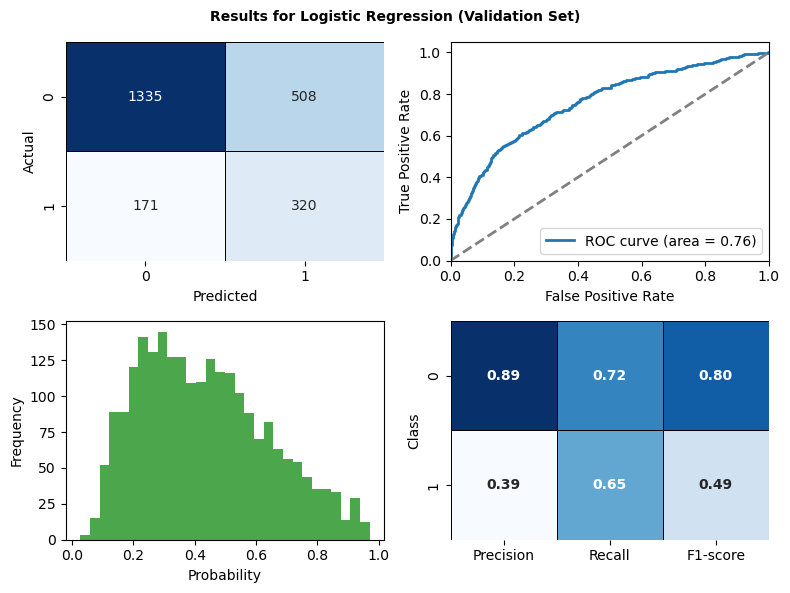


Random Forest Cross-Validation Results:
Mean F1-score: 0.4447 (+/- 0.0447)

Random Forest (Test Set):
Test Accuracy: 0.8103
Test Precision: 0.5091
Test Recall: 0.3742
Test F1-score: 0.4313

Random Forest (Validation Set):
  Val Accuracy: 0.8033
  Val Precision: 0.5500
  Val Recall: 0.3585
  Val F1-score: 0.4340
  Val AUC: 0.7408


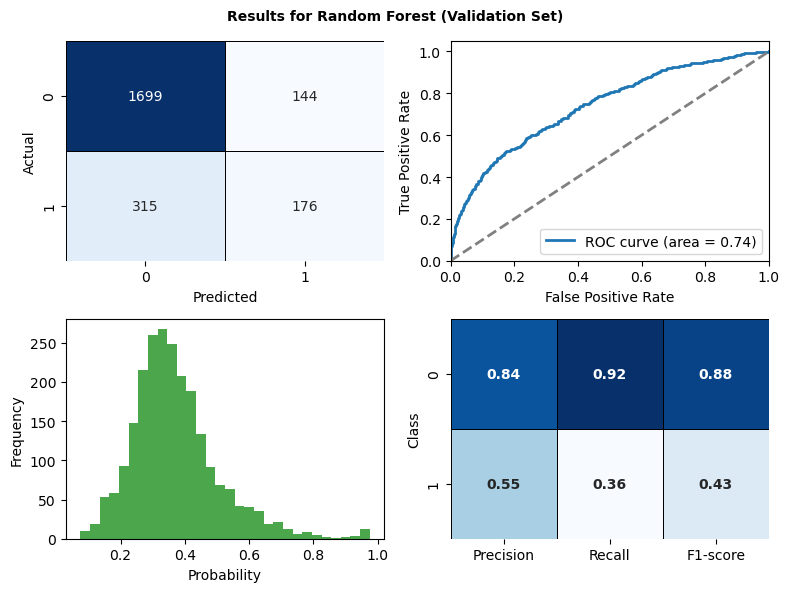


Gradient Boosting Cross-Validation Results:
Mean F1-score: 0.2225 (+/- 0.0347)

Gradient Boosting (Test Set):
Test Accuracy: 0.8257
Test Precision: 0.8000
Test Recall: 0.1247
Test F1-score: 0.2158

Gradient Boosting (Validation Set):
  Val Accuracy: 0.8068
  Val Precision: 0.7941
  Val Recall: 0.1100
  Val F1-score: 0.1932
  Val AUC: 0.7315


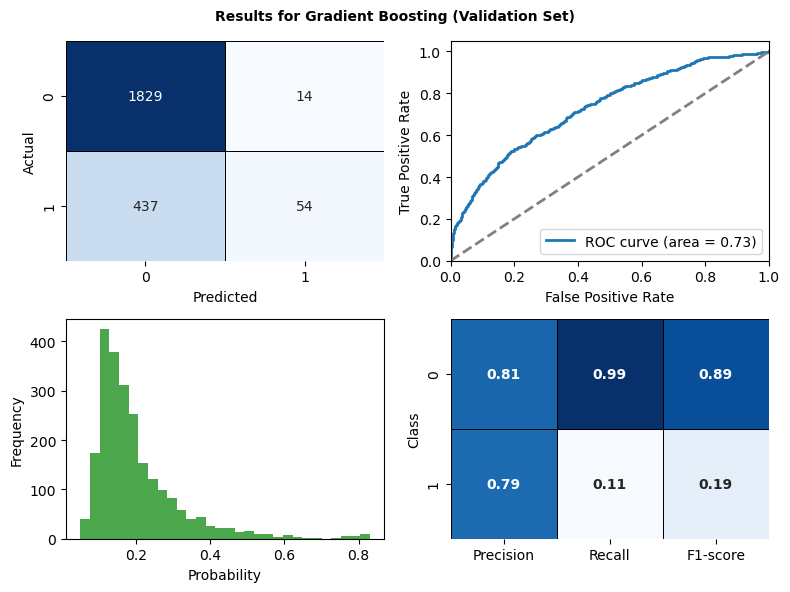


SVM Cross-Validation Results:
Mean F1-score: 0.4748 (+/- 0.0184)

SVM (Test Set):
Test Accuracy: 0.7310
Test Precision: 0.3811
Test Recall: 0.6392
Test F1-score: 0.4775

SVM (Validation Set):
  Val Accuracy: 0.8098
  Val Precision: 0.6621
  Val Recall: 0.1955
  Val F1-score: 0.3019
  Val AUC: 0.7593


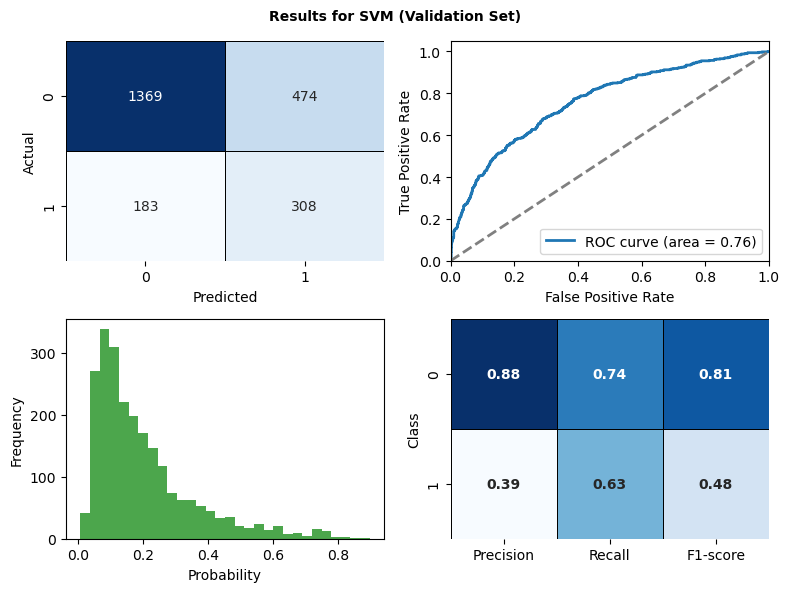

Training sequential API model...

Sequential Evaluation Results
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8254 - loss: 0.4319
Test Loss: 0.4263, Test Accuracy: 0.8351
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Sequential (Test Set):
Test Accuracy: 0.8351
Test Precision: 0.6951
Test Recall: 0.2539
Test F1-score: 0.3719
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Sequential (Validation Set):
  Val Accuracy: 0.8183
  Val Precision: 0.6754
  Val Recall: 0.2627
  Val F1-score: 0.3783
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


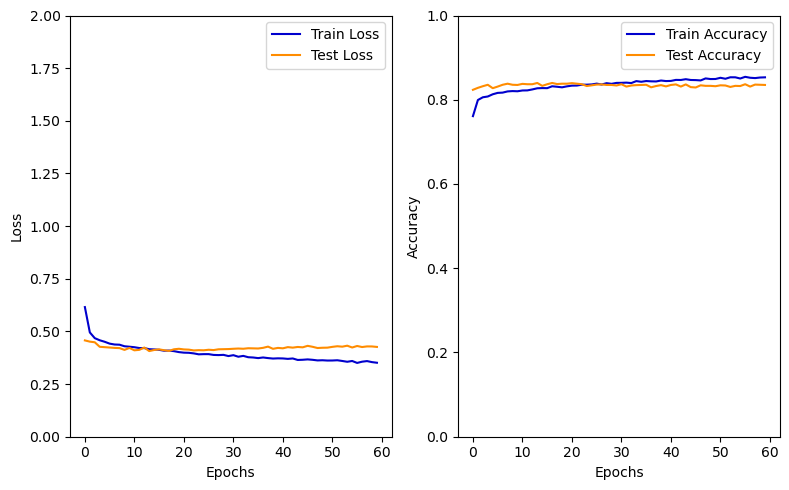

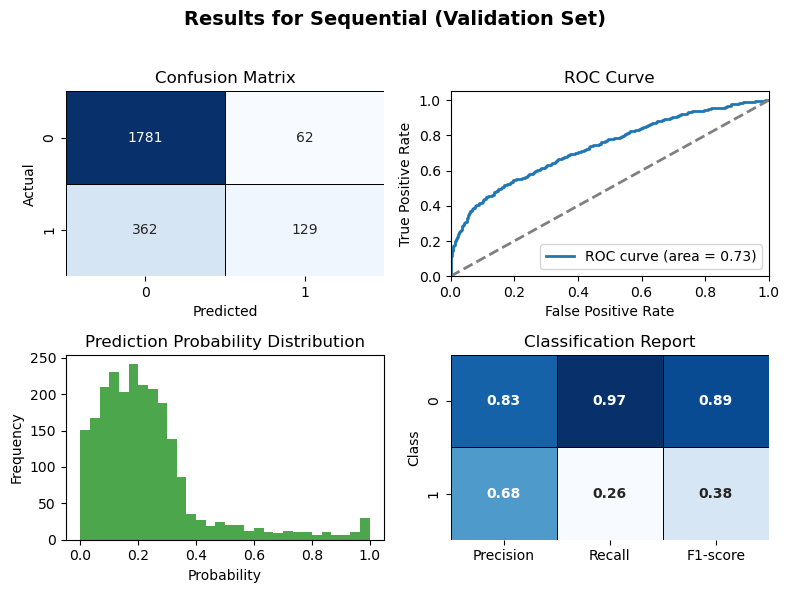

In [11]:
def parallel_cross_val(model, X_train, y_train, cv=5):
    return cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)

def cross_validate_and_evaluate(model, X_train, y_train, X_test, y_test, X_val, y_val, model_name, cv=5):
    cv_scores = parallel_cross_val(model, X_train, y_train, cv=cv)
    
    print(f"\n{model_name} Cross-Validation Results:")
    print(f"Mean F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    model.fit(X_train, y_train)
    
    y_test_pred = model.predict(X_test)
    print(f"\n{model_name} (Test Set):")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Test Precision: {precision_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test Recall: {recall_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test F1-score: {f1_score(y_test, y_test_pred, zero_division=1):.4f}")
    
    if hasattr(model, "predict_proba"):
        y_val_pred_proba = model.predict_proba(X_val)[:, 1]
        y_val_pred = (y_val_pred_proba >= 0.5).astype(int)  # Threshold set to 0.5
        val_results = {
            'Val Accuracy': accuracy_score(y_val, y_val_pred),
            'Val Precision': precision_score(y_val, y_val_pred, zero_division=1),
            'Val Recall': recall_score(y_val, y_val_pred, zero_division=1),
            'Val F1-score': f1_score(y_val, y_val_pred, zero_division=1),
            'Val AUC': roc_auc_score(y_val, y_val_pred_proba)
        }
        
        print(f"\n{model_name} (Validation Set):")
        for metric, value in val_results.items():
            print(f"  {metric}: {value:.4f}")
                
    Evaluation = ModelEvaluation(model, X_val, y_val, f'{model_name} (Validation Set)')    
    Evaluation.plot_evaluation()

# models = {
#     "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=500),
#     "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42),
#     "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
#     "SVM": SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42, probability=True)
# }

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=500),
    "Random Forest": RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    ),
    "SVM": SVC(
        kernel='linear',
        C=0.5,
        class_weight='balanced',
        random_state=42,
        probability=True
    )
}

for name, model in models.items():
    cross_validate_and_evaluate(model, X_train, y_train, X_test, y_test, X_val, y_val, name, cv=5)
    
    

def sequential_model(X_train, y_train, X_test, y_test, X_val, y_val):
    
    X_train = tf.constant(X_train)
    y_train = tf.constant(y_train)
    X_test = tf.constant(X_test)
    y_test = tf.constant(y_test)
    X_val = tf.constant(X_val)
    y_val = tf.constant(y_val)
    
    # model = Sequential([
    #     Dense(128, activation="relu"),
    #     Dropout(0.5),
    #     Dense(256, activation="relu"),
    #     Dropout(0.5),
    #     Dense(128, activation="relu"),
    #     Dense(1, activation="sigmoid")
    # ])
    
    model = Sequential([
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam", #tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )

    # Fit the model
    print('Training sequential API model...')
    history = model.fit(
        X_train,
        y_train,
        epochs=60,
        validation_data=(X_test, y_test),
        verbose=0
    )

    model_name = 'Sequential'
    print(f"\n{model_name} Evaluation Results")
    res = model.evaluate(X_test, y_test)
    print(f"Test Loss: {res[0]:.4f}, Test Accuracy: {res[1]:.4f}")
    
    
    
    y_test_pred = (model.predict(X_test) >= 0.5).astype(int)
    print(f"\n{model_name} (Test Set):")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Test Precision: {precision_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test Recall: {recall_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test F1-score: {f1_score(y_test, y_test_pred, zero_division=1):.4f}")


    y_val_pred = (model.predict(X_val) >= 0.5).astype(int)
    val_results = {
        'Val Accuracy': accuracy_score(y_val, y_val_pred),
        'Val Precision': precision_score(y_val, y_val_pred, zero_division=1),
        'Val Recall': recall_score(y_val, y_val_pred, zero_division=1),
        'Val F1-score': f1_score(y_val, y_val_pred, zero_division=1)
    }

    print(f"\n{model_name} (Validation Set):")
    for metric, value in val_results.items():
        print(f"  {metric}: {value:.4f}")
        
    Evaluation = TfEvaluation(model, X_val, y_val, f'{model_name} (Validation Set)', history)
    Evaluation.plot_history()        
    Evaluation.plot_evaluation()


sequential_model(X_train, y_train, X_test, y_test, X_val, y_val)


### 2. [ProNE](https://github.com/VHRanger/nodevectors/blob/master/nodevectors/prone.py)

In [12]:
# Initialize ProNE model
prone_model = ProNE(
    n_components=64,
    step=5,
    mu=0.2,
    theta=0.5,
    exponent=0.75,
    verbose=True
)

# Fit model to graph
print("Training ProNE model...")
node_embeddings = prone_model.fit_transform(G) # Returns node vectors

# Save ProNE model
print('Saving the ProNE model...')
prone_model.save('../models/ProNE/prone_model')

# Save embeddings in Gensim format
print('Saving embeddings in Gensim format...')
node_ids = list(map(str, prone_model.model.keys()))  # Convert node IDs to strings
vectors = list(prone_model.model.values())  # Extract node vectors

# Create KeyedVectors instance and add vectors
kv = KeyedVectors(vector_size=64)
kv.add_vectors(node_ids, vectors)

# Save vectors in Word2Vec format
kv.save_word2vec_format("../models/ProNE/wheel_model.bin", binary=True)

# Load embeddings using Gensim
print('Loading embeddings...')
embeddings = KeyedVectors.load_word2vec_format("../models/ProNE/wheel_model.bin", binary=True)

# Print embeddings for a specific node (e.g., cardiovascular disease)
print(f"Embeddings for node '{diseases[0]}':\n")
print(embeddings[str(diseases[0])])  # Node ID must be a string for Gensim


Training ProNE model...
Saving the ProNE model...
Saving embeddings in Gensim format...
Loading embeddings...
Embeddings for node 'cardiovascular':

[-0.40894833  0.3023638   0.08351784  0.18423864  0.01618532  0.05468361
  0.073101    0.05285247 -0.02587377  0.41136548 -0.0179046   0.04053626
 -0.05745827  0.00351255 -0.14356722  0.2077857  -0.11791983 -0.0402164
  0.03171301 -0.04277415  0.22797604  0.08087319 -0.0089884  -0.09455205
  0.02223012 -0.08103078 -0.03533067  0.05483652 -0.05618136 -0.0705708
  0.05669573 -0.14920516  0.00403467  0.06207356  0.03855481 -0.00655237
  0.06085053  0.3068858  -0.03222796 -0.00136737 -0.08014394  0.13418417
  0.05178208 -0.02245593 -0.13500774 -0.05755085 -0.06088192  0.0359714
  0.2386319   0.04899428 -0.05754622  0.10752554 -0.04312421 -0.05613456
  0.04320153 -0.056397   -0.01030494 -0.0380851   0.00248612  0.04228633
  0.03524438  0.08442288 -0.05687818 -0.24808457]


In [13]:
# Load embeddings with Gensim
print('Loading embeddings...')
embeddings = KeyedVectors.load_word2vec_format("../models/ProNE/wheel_model.bin", binary=True)

# Function to get edge features
def get_edge_features(edge, embeddings):
    return embeddings[edge[0]] * embeddings[edge[1]]

# Generate features for positive and negative edges
X_positive = np.array([get_edge_features(edge, embeddings) for edge in positive_edges])
X_negative = np.array([get_edge_features(edge, embeddings) for edge in negative_edges])
X = np.vstack((X_positive, X_negative))
y = np.array([1] * len(positive_edges) + [0] * len(negative_edges))

# Print sample data
print(f'\nSample from X: {X[0:1]}')
print(f'Sample from y: {y[0:1]}')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


Loading embeddings...

Sample from X: [[ 6.9203570e-02  4.0409017e-02  1.2051271e-02  1.1191980e-03
  -8.4341917e-04 -1.3130918e-02 -4.4526565e-03  2.7376479e-03
   5.6317933e-03  7.8001902e-02 -3.7024708e-03 -1.3348298e-03
  -1.4951227e-03  1.6917170e-03  2.8231516e-02  3.4501913e-03
   6.5523987e-03  6.9253915e-03 -4.2296234e-03  1.4193420e-03
   5.9939668e-02 -3.4950634e-03  3.7393803e-04  1.2048734e-02
   3.4263311e-03  3.0481080e-03  1.0767351e-02  3.0628880e-03
   1.1163723e-02  5.3596008e-03  2.2961793e-02  3.2622773e-02
  -2.1537938e-03  1.0198054e-02 -1.2373329e-03 -2.7555239e-03
   2.7410511e-03 -5.3328474e-04 -1.1061504e-03 -7.4375337e-03
  -2.0793611e-03  1.8634373e-02  1.5091080e-03  1.7418519e-02
   3.6865857e-03  1.6266188e-03  1.1941805e-02  4.6178475e-03
   1.4629507e-05 -1.1506613e-02  3.8991915e-04  2.9241877e-02
  -7.5284569e-03  1.0763817e-04 -1.2721756e-02 -1.4987437e-03
  -2.8880811e-03  2.2493647e-03 -2.1904054e-04 -4.9085789e-03
   1.1407656e-02 -3.3324063e-03 


Logistic Regression Cross-Validation Results:
Mean F1-score: 0.4328 (+/- 0.0290)

Logistic Regression (Test Set):
Test Accuracy: 0.6715
Test Precision: 0.3112
Test Recall: 0.5835
Test F1-score: 0.4059

Logistic Regression (Validation Set):
  Val Accuracy: 0.6658
  Val Precision: 0.3345
  Val Recall: 0.5947
  Val F1-score: 0.4282
  Val AUC: 0.6973


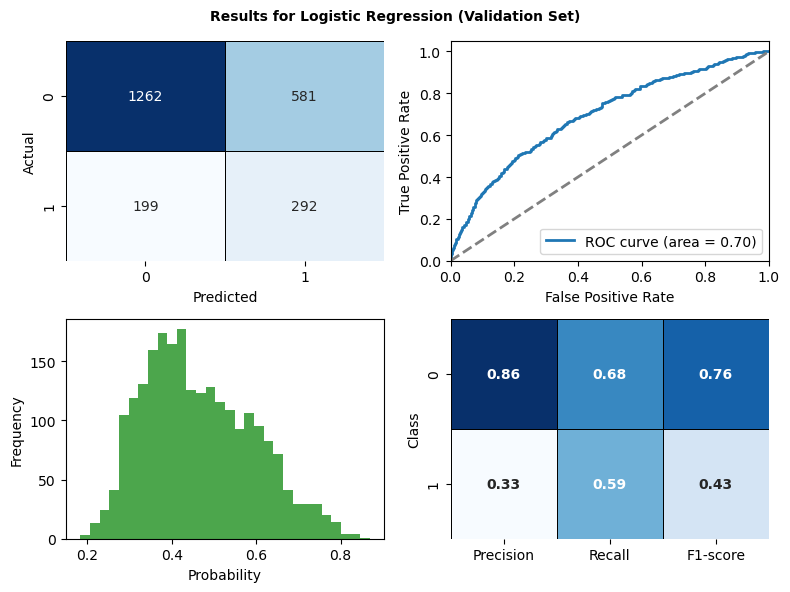


Random Forest Cross-Validation Results:
Mean F1-score: 0.4597 (+/- 0.0242)

Random Forest (Test Set):
Test Accuracy: 0.8004
Test Precision: 0.4806
Test Recall: 0.4699
Test F1-score: 0.4752

Random Forest (Validation Set):
  Val Accuracy: 0.7768
  Val Precision: 0.4688
  Val Recall: 0.4582
  Val F1-score: 0.4634
  Val AUC: 0.7265


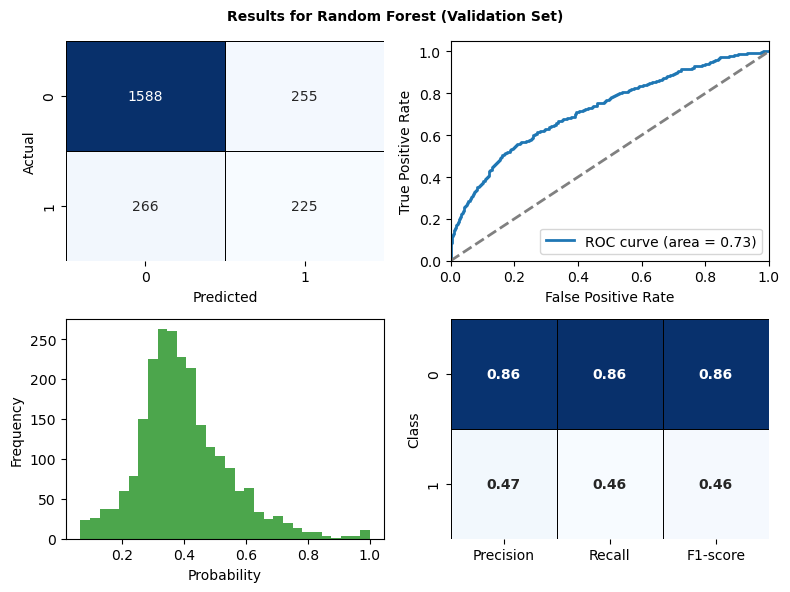


Gradient Boosting Cross-Validation Results:
Mean F1-score: 0.2250 (+/- 0.0284)

Gradient Boosting (Test Set):
Test Accuracy: 0.8244
Test Precision: 0.7349
Test Recall: 0.1359
Test F1-score: 0.2293

Gradient Boosting (Validation Set):
  Val Accuracy: 0.8051
  Val Precision: 0.7195
  Val Recall: 0.1202
  Val F1-score: 0.2059
  Val AUC: 0.7208


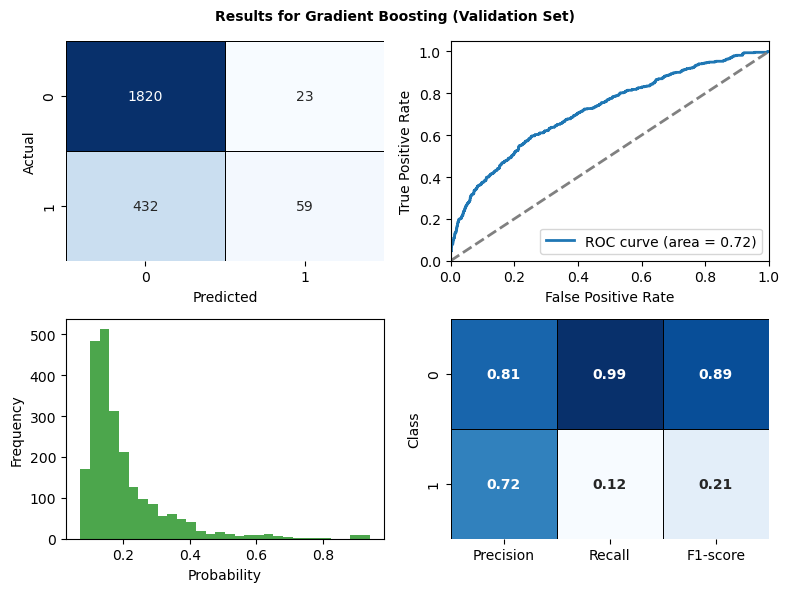


SVM Cross-Validation Results:
Mean F1-score: 0.4263 (+/- 0.0297)

SVM (Test Set):
Test Accuracy: 0.6938
Test Precision: 0.3245
Test Recall: 0.5479
Test F1-score: 0.4076

SVM (Validation Set):
  Val Accuracy: 0.7935
  Val Precision: 0.5556
  Val Recall: 0.0916
  Val F1-score: 0.1573
  Val AUC: 0.6979


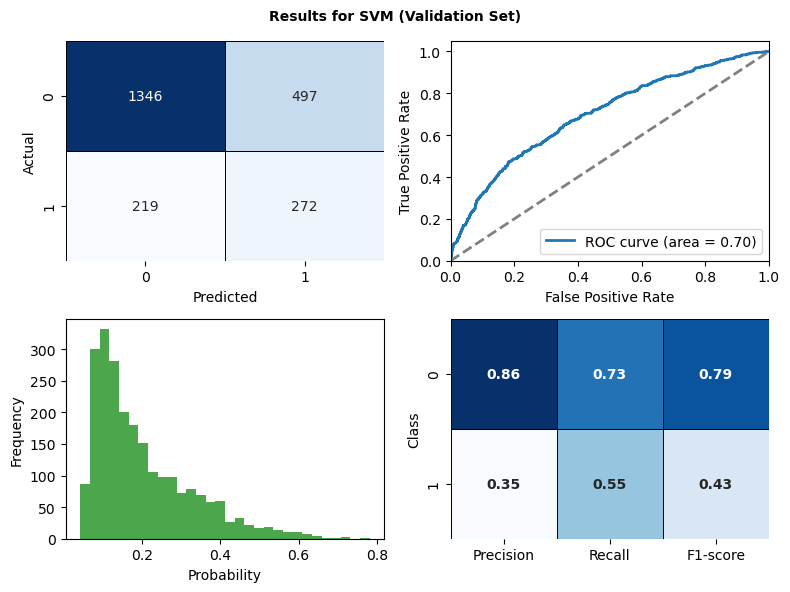

Training sequential API model...

Sequential Evaluation Results
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8211 - loss: 0.4302
Test Loss: 0.4093, Test Accuracy: 0.8347
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Sequential (Test Set):
Test Accuracy: 0.8347
Test Precision: 0.7299
Test Recall: 0.2227
Test F1-score: 0.3413
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Sequential (Validation Set):
  Val Accuracy: 0.8179
  Val Precision: 0.7260
  Val Recall: 0.2159
  Val F1-score: 0.3328
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


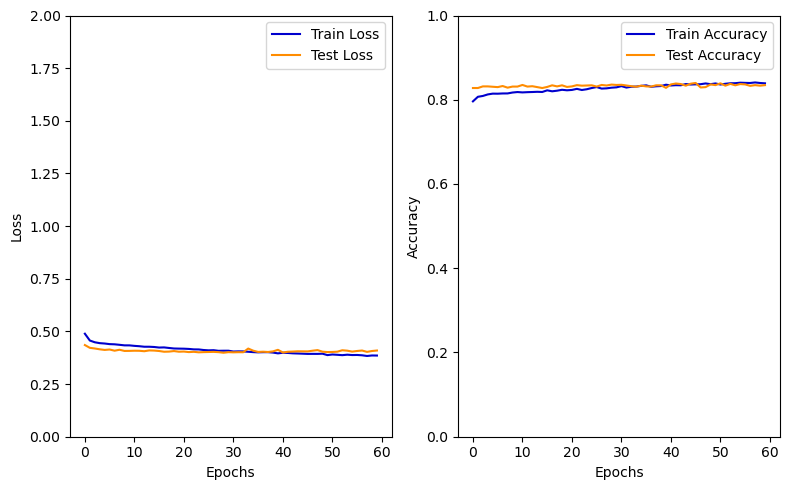

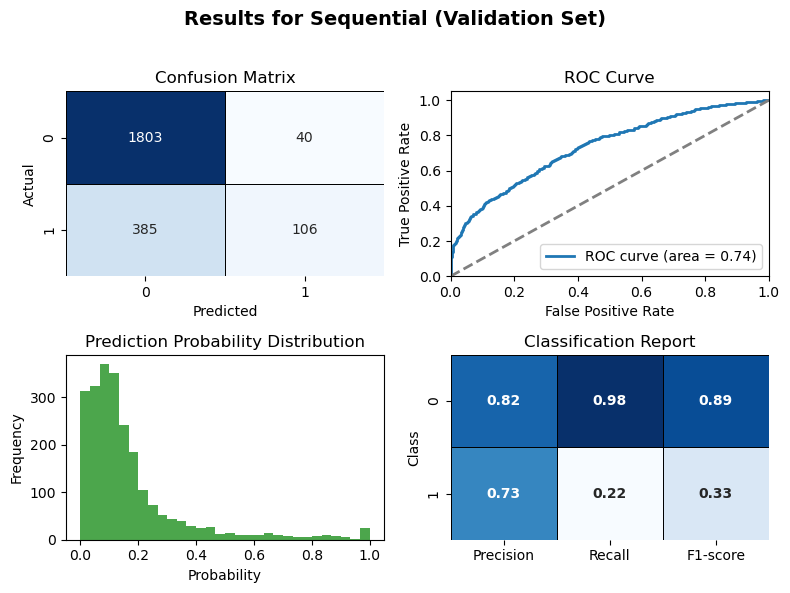

In [14]:
def parallel_cross_val(model, X_train, y_train, cv=5):
    return cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)

def cross_validate_and_evaluate(model, X_train, y_train, X_test, y_test, X_val, y_val, model_name, cv=5):
    cv_scores = parallel_cross_val(model, X_train, y_train, cv=cv)
    
    print(f"\n{model_name} Cross-Validation Results:")
    print(f"Mean F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    model.fit(X_train, y_train)
    
    y_test_pred = model.predict(X_test)
    print(f"\n{model_name} (Test Set):")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Test Precision: {precision_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test Recall: {recall_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test F1-score: {f1_score(y_test, y_test_pred, zero_division=1):.4f}")
    
    if hasattr(model, "predict_proba"):
        y_val_pred_proba = model.predict_proba(X_val)[:, 1]
        y_val_pred = (y_val_pred_proba >= 0.5).astype(int)  # Threshold set to 0.5
        val_results = {
            'Val Accuracy': accuracy_score(y_val, y_val_pred),
            'Val Precision': precision_score(y_val, y_val_pred, zero_division=1),
            'Val Recall': recall_score(y_val, y_val_pred, zero_division=1),
            'Val F1-score': f1_score(y_val, y_val_pred, zero_division=1),
            'Val AUC': roc_auc_score(y_val, y_val_pred_proba)
        }
        
        print(f"\n{model_name} (Validation Set):")
        for metric, value in val_results.items():
            print(f"  {metric}: {value:.4f}")
                
    Evaluation = ModelEvaluation(model, X_val, y_val, f'{model_name} (Validation Set)')    
    Evaluation.plot_evaluation()

# models = {
#     "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=500),
#     "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42),
#     "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
#     "SVM": SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42, probability=True)
# }

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=500),
    "Random Forest": RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    ),
    "SVM": SVC(
        kernel='linear',
        C=0.5,
        class_weight='balanced',
        random_state=42,
        probability=True
    )
}

for name, model in models.items():
    cross_validate_and_evaluate(model, X_train, y_train, X_test, y_test, X_val, y_val, name, cv=5)
    
    

def sequential_model(X_train, y_train, X_test, y_test, X_val, y_val):
    
    X_train = tf.constant(X_train)
    y_train = tf.constant(y_train)
    X_test = tf.constant(X_test)
    y_test = tf.constant(y_test)
    X_val = tf.constant(X_val)
    y_val = tf.constant(y_val)
    
    # model = Sequential([
    #     Dense(128, activation="relu"),
    #     Dropout(0.5),
    #     Dense(256, activation="relu"),
    #     Dropout(0.5),
    #     Dense(128, activation="relu"),
    #     Dense(1, activation="sigmoid")
    # ])
    
    model = Sequential([
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam", #tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )

    # Fit the model
    print('Training sequential API model...')
    history = model.fit(
        X_train,
        y_train,
        epochs=60,
        validation_data=(X_test, y_test),
        verbose=0
    )

    model_name = 'Sequential'
    print(f"\n{model_name} Evaluation Results")
    res = model.evaluate(X_test, y_test)
    print(f"Test Loss: {res[0]:.4f}, Test Accuracy: {res[1]:.4f}")
    
    
    
    y_test_pred = (model.predict(X_test) >= 0.5).astype(int)
    print(f"\n{model_name} (Test Set):")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Test Precision: {precision_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test Recall: {recall_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test F1-score: {f1_score(y_test, y_test_pred, zero_division=1):.4f}")


    y_val_pred = (model.predict(X_val) >= 0.5).astype(int)
    val_results = {
        'Val Accuracy': accuracy_score(y_val, y_val_pred),
        'Val Precision': precision_score(y_val, y_val_pred, zero_division=1),
        'Val Recall': recall_score(y_val, y_val_pred, zero_division=1),
        'Val F1-score': f1_score(y_val, y_val_pred, zero_division=1)
    }

    print(f"\n{model_name} (Validation Set):")
    for metric, value in val_results.items():
        print(f"  {metric}: {value:.4f}")
        
    Evaluation = TfEvaluation(model, X_val, y_val, f'{model_name} (Validation Set)', history)
    Evaluation.plot_history()        
    Evaluation.plot_evaluation()


sequential_model(X_train, y_train, X_test, y_test, X_val, y_val)


### 3. [GGVec](https://github.com/VHRanger/nodevectors/blob/master/nodevectors/ggvec.py)

In [15]:
# Initialize GGVec model
ggvec_model = GGVec(
    n_components=64,       
    order=3,     
    verbose=True 
)

# Fit model to graph
print("Training GGVec model...")
node_embeddings = ggvec_model.fit_transform(G) # Returns node vectors

# Save GGVec model
print('Saving the GGVec model...')
ggvec_model.save('../models/GGVec/ggvec_model')

# Save embeddings in Gensim format
print('Saving embeddings in Gensim format...')
node_ids = list(map(str, ggvec_model.model.keys())) # Convert node IDs to strings
vectors = list(ggvec_model.model.values())  # Extract node vectors

# Create KeyedVectors instance and add vectors
kv = KeyedVectors(vector_size=64)
kv.add_vectors(node_ids, vectors)

# Save in Word2Vec format
kv.save_word2vec_format("../models/GGVec/wheel_model.bin", binary=True)

# Load embeddings using Gensim
print('Loading embeddings...')
embeddings = KeyedVectors.load_word2vec_format("../models/GGVec/wheel_model.bin", binary=True)

# Print embeddings for a specific node (e.g., cardiovascular disease)
print(f"Embeddings for node '{diseases[0]}':\n")
print(embeddings[str(diseases[0])])

Training GGVec model...


Loss: 0.0055	:   9%|▉         | 33/350 [03:53<37:25,  7.08s/it]

Converged! Loss: 0.0055



Loss: 0.0018	:  10%|█         | 35/350 [06:16<56:31, 10.77s/it] 

Converged! Loss: 0.0018
Saving the GGVec model...


Saving embeddings in Gensim format...
Loading embeddings...
Embeddings for node 'cardiovascular':

[ 0.12615398 -0.06090871  0.07192682  0.02966005 -0.1415043   0.0743582
  0.04022341  0.1418389   0.01688798  0.02005387 -0.04313318 -0.12010048
  0.09696637  0.04335532  0.10661063 -0.15218242  0.08395374 -0.01545873
  0.07585838 -0.07069642  0.07120828  0.1829854  -0.04442496  0.0924157
  0.14197482 -0.06130889  0.05156834  0.15976606 -0.0257433  -0.23214765
 -0.05307818  0.11422911  0.09153085  0.1468238  -0.08378007  0.02071112
 -0.04505586  0.07040602 -0.14211121  0.0584876   0.08743849 -0.01197261
  0.14952774 -0.02821963 -0.02163492  0.0541945   0.04099316  0.24904124
  0.01501423 -0.07534879  0.00935139 -0.16751131  0.14574833  0.09946458
 -0.08257581 -0.06325236 -0.00857405  0.00502697  0.20753293 -0.08564018
  0.17075771  0.14488105 -0.11833178 -0.15107496]


In [16]:
# Load embeddings with Gensim
print('Loading embeddings...')
embeddings = KeyedVectors.load_word2vec_format("../models/GGVec/wheel_model.bin", binary=True)

# Function to get edge features
def get_edge_features(edge, embeddings):
    return embeddings[edge[0]] * embeddings[edge[1]]

# Generate features for positive and negative edges
X_positive = np.array([get_edge_features(edge, embeddings) for edge in positive_edges])
X_negative = np.array([get_edge_features(edge, embeddings) for edge in negative_edges])
X = np.vstack((X_positive, X_negative))
y = np.array([1] * len(positive_edges) + [0] * len(negative_edges))

# Print sample data
print(f'Sample from X: {X[0:1]}')
print(f'Sample from y: {y[0:1]}')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


Loading embeddings...
Sample from X: [[ 2.40876456e-04  1.03870574e-04  8.44949216e-04 -3.52013478e-04
   2.33472958e-02  3.08774505e-03 -1.80993194e-03  4.88689076e-03
   1.46215048e-03  4.84941353e-04 -2.87692156e-03  1.73007522e-03
   6.94031082e-03 -3.27752717e-03  5.54563152e-03  7.61531573e-03
   9.57222097e-03  7.42788601e-04  2.80042924e-03  2.96573061e-03
   2.59293593e-04 -4.62038023e-03 -7.69161968e-04 -9.36484803e-03
   9.35714506e-03  1.88737840e-03  1.35035662e-03 -1.63635425e-03
   2.47182645e-04 -6.97511854e-03 -1.46372430e-03 -5.77389728e-04
  -3.32567957e-03  1.77955385e-02 -1.54990575e-03 -8.39256565e-04
  -9.68977169e-04  2.04476062e-03 -9.14874894e-04 -3.73801868e-03
   1.38798740e-03 -3.71638918e-04  1.46656553e-03  7.20971555e-04
   9.23298940e-04 -2.04830547e-03  2.81311409e-03 -1.66868663e-03
  -1.16219325e-03  9.38094454e-04  1.24141197e-05  2.08207052e-02
   1.75515271e-03  8.01448431e-03  5.05127292e-03 -1.62269210e-03
   9.61347250e-04 -3.26789421e-04  4.70


Logistic Regression Cross-Validation Results:
Mean F1-score: 0.4318 (+/- 0.0111)

Logistic Regression (Test Set):
Test Accuracy: 0.6869
Test Precision: 0.3242
Test Recall: 0.5791
Test F1-score: 0.4157

Logistic Regression (Validation Set):
  Val Accuracy: 0.6769
  Val Precision: 0.3418
  Val Recall: 0.5784
  Val F1-score: 0.4297
  Val AUC: 0.7130


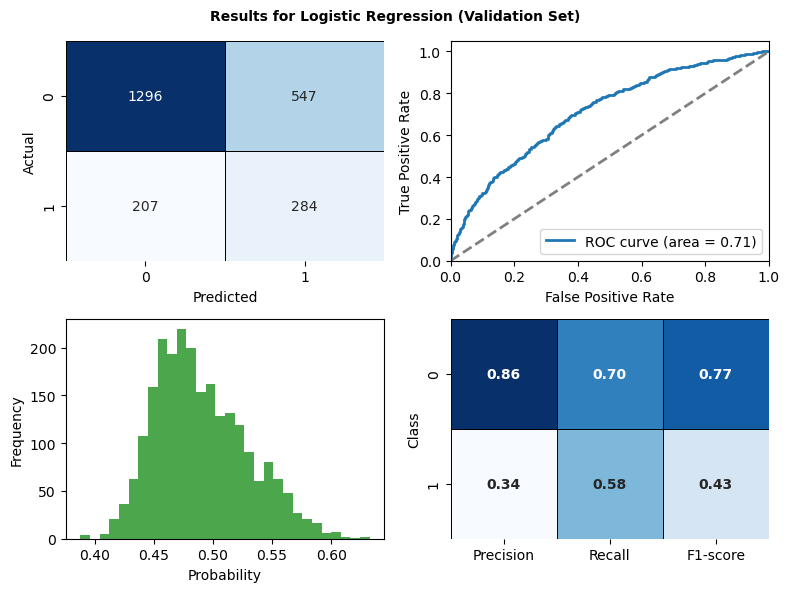


Random Forest Cross-Validation Results:
Mean F1-score: 0.5069 (+/- 0.0197)

Random Forest (Test Set):
Test Accuracy: 0.8424
Test Precision: 0.6128
Test Recall: 0.4900
Test F1-score: 0.5446

Random Forest (Validation Set):
  Val Accuracy: 0.8171
  Val Precision: 0.5856
  Val Recall: 0.4460
  Val F1-score: 0.5064
  Val AUC: 0.7923


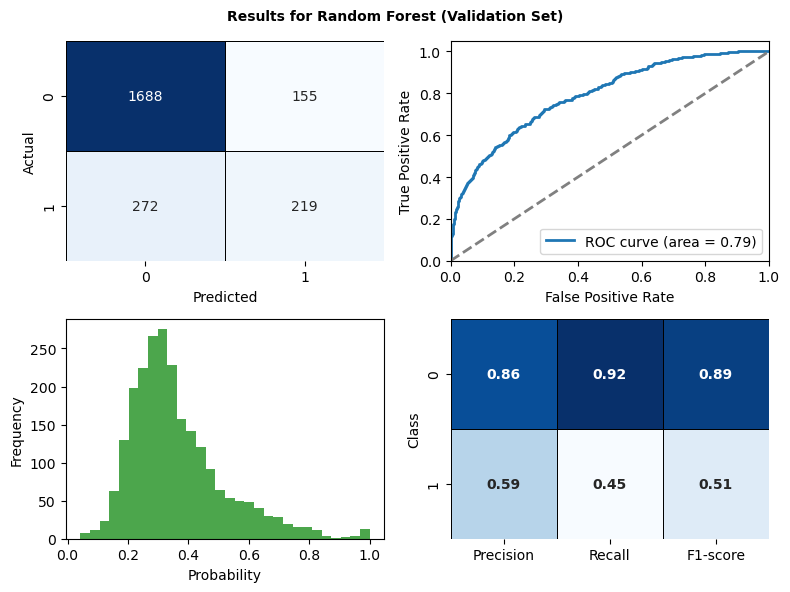


Gradient Boosting Cross-Validation Results:
Mean F1-score: 0.3459 (+/- 0.0420)

Gradient Boosting (Test Set):
Test Accuracy: 0.8407
Test Precision: 0.8291
Test Recall: 0.2160
Test F1-score: 0.3428

Gradient Boosting (Validation Set):
  Val Accuracy: 0.8192
  Val Precision: 0.7899
  Val Recall: 0.1914
  Val F1-score: 0.3082
  Val AUC: 0.7693


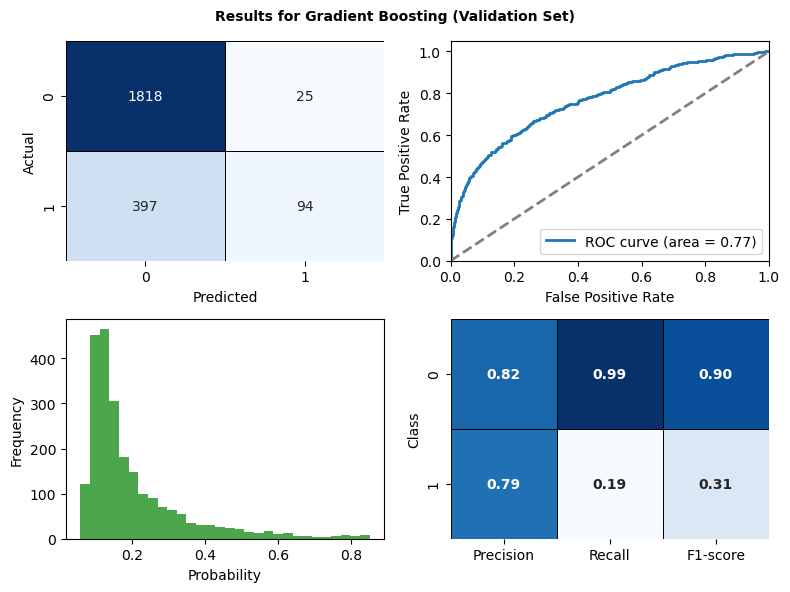


SVM Cross-Validation Results:
Mean F1-score: 0.0764 (+/- 0.2677)

SVM (Test Set):
Test Accuracy: 0.8227
Test Precision: 0.7333
Test Recall: 0.1225
Test F1-score: 0.2099

SVM (Validation Set):
  Val Accuracy: 0.7896
  Val Precision: 1.0000
  Val Recall: 0.0000
  Val F1-score: 0.0000
  Val AUC: 0.7130


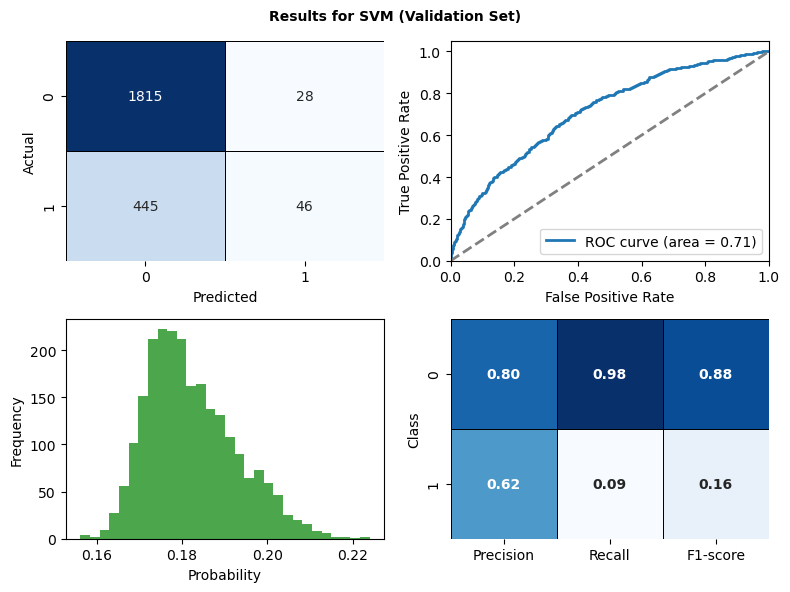

Training sequential API model...

Sequential Evaluation Results
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8809 - loss: 0.3159
Test Loss: 0.2975, Test Accuracy: 0.8814
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Sequential (Test Set):
Test Accuracy: 0.8814
Test Precision: 0.8707
Test Recall: 0.4499
Test F1-score: 0.5932
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Sequential (Validation Set):
  Val Accuracy: 0.8595
  Val Precision: 0.8655
  Val Recall: 0.3931
  Val F1-score: 0.5406
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


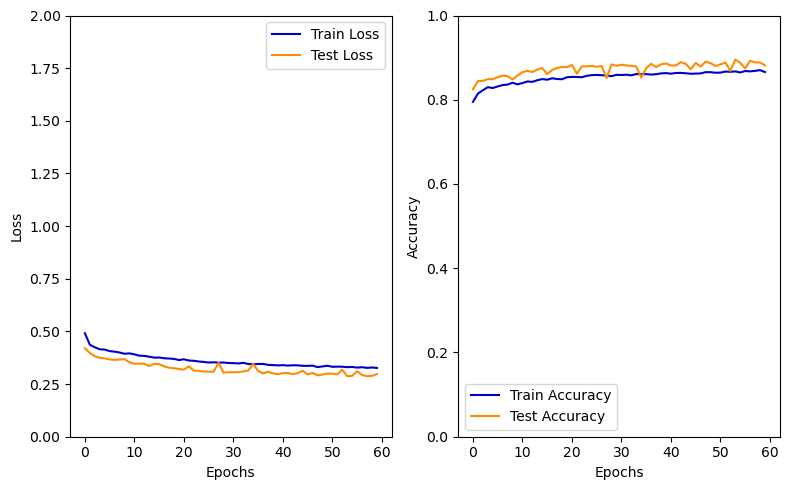

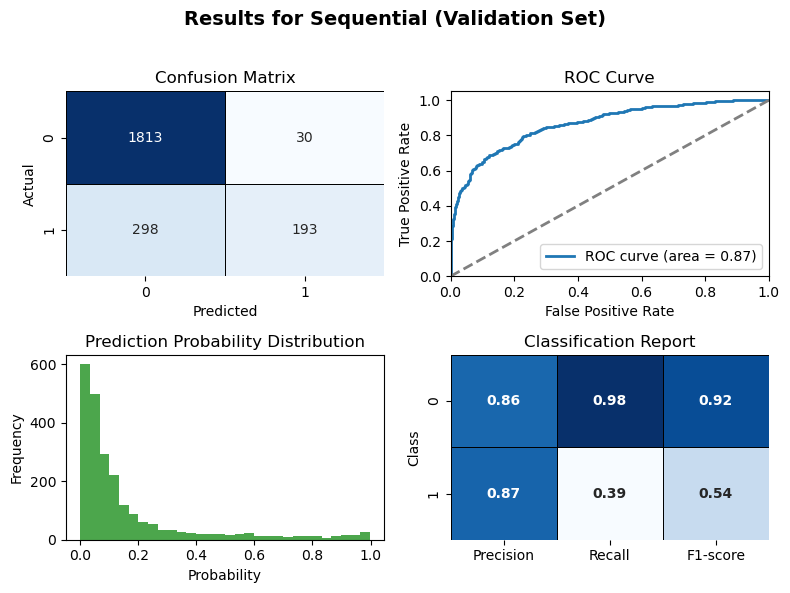

In [17]:
def parallel_cross_val(model, X_train, y_train, cv=5):
    return cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)

def cross_validate_and_evaluate(model, X_train, y_train, X_test, y_test, X_val, y_val, model_name, cv=5):
    cv_scores = parallel_cross_val(model, X_train, y_train, cv=cv)
    
    print(f"\n{model_name} Cross-Validation Results:")
    print(f"Mean F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    model.fit(X_train, y_train)
    
    y_test_pred = model.predict(X_test)
    print(f"\n{model_name} (Test Set):")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Test Precision: {precision_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test Recall: {recall_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test F1-score: {f1_score(y_test, y_test_pred, zero_division=1):.4f}")
    
    if hasattr(model, "predict_proba"):
        y_val_pred_proba = model.predict_proba(X_val)[:, 1]
        y_val_pred = (y_val_pred_proba >= 0.5).astype(int)  # Threshold set to 0.5
        val_results = {
            'Val Accuracy': accuracy_score(y_val, y_val_pred),
            'Val Precision': precision_score(y_val, y_val_pred, zero_division=1),
            'Val Recall': recall_score(y_val, y_val_pred, zero_division=1),
            'Val F1-score': f1_score(y_val, y_val_pred, zero_division=1),
            'Val AUC': roc_auc_score(y_val, y_val_pred_proba)
        }
        
        print(f"\n{model_name} (Validation Set):")
        for metric, value in val_results.items():
            print(f"  {metric}: {value:.4f}")
                
    Evaluation = ModelEvaluation(model, X_val, y_val, f'{model_name} (Validation Set)')    
    Evaluation.plot_evaluation()

# models = {
#     "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=500),
#     "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42),
#     "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
#     "SVM": SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42, probability=True)
# }

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=500),
    "Random Forest": RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    ),
    "SVM": SVC(
        kernel='linear',
        C=0.5,
        class_weight='balanced',
        random_state=42,
        probability=True
    )
}

for name, model in models.items():
    cross_validate_and_evaluate(model, X_train, y_train, X_test, y_test, X_val, y_val, name, cv=5)
    
    

def sequential_model(X_train, y_train, X_test, y_test, X_val, y_val):
    
    X_train = tf.constant(X_train)
    y_train = tf.constant(y_train)
    X_test = tf.constant(X_test)
    y_test = tf.constant(y_test)
    X_val = tf.constant(X_val)
    y_val = tf.constant(y_val)
    
    # model = Sequential([
    #     Dense(128, activation="relu"),
    #     Dropout(0.5),
    #     Dense(256, activation="relu"),
    #     Dropout(0.5),
    #     Dense(128, activation="relu"),
    #     Dense(1, activation="sigmoid")
    # ])
    
    model = Sequential([
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam", #tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )

    # Fit the model
    print('Training sequential API model...')
    history = model.fit(
        X_train,
        y_train,
        epochs=60,
        validation_data=(X_test, y_test),
        verbose=0
    )

    model_name = 'Sequential'
    print(f"\n{model_name} Evaluation Results")
    res = model.evaluate(X_test, y_test)
    print(f"Test Loss: {res[0]:.4f}, Test Accuracy: {res[1]:.4f}")
    
    
    
    y_test_pred = (model.predict(X_test) >= 0.5).astype(int)
    print(f"\n{model_name} (Test Set):")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Test Precision: {precision_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test Recall: {recall_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test F1-score: {f1_score(y_test, y_test_pred, zero_division=1):.4f}")


    y_val_pred = (model.predict(X_val) >= 0.5).astype(int)
    val_results = {
        'Val Accuracy': accuracy_score(y_val, y_val_pred),
        'Val Precision': precision_score(y_val, y_val_pred, zero_division=1),
        'Val Recall': recall_score(y_val, y_val_pred, zero_division=1),
        'Val F1-score': f1_score(y_val, y_val_pred, zero_division=1)
    }

    print(f"\n{model_name} (Validation Set):")
    for metric, value in val_results.items():
        print(f"  {metric}: {value:.4f}")
        
    Evaluation = TfEvaluation(model, X_val, y_val, f'{model_name} (Validation Set)', history)
    Evaluation.plot_history()        
    Evaluation.plot_evaluation()


sequential_model(X_train, y_train, X_test, y_test, X_val, y_val)


## Simple Node Embedding

In [18]:
def simple_node_embedding(G, dim=64):
    print("Generating simple node embeddings...")
    embeddings = {}
    for node in G.nodes():
        # Use node degree as a feature
        degree = G.degree(node)
        # Use average neighbor degree as another feature
        neighbor_degrees = [G.degree(n) for n in G.neighbors(node)]
        avg_neighbor_degree = np.mean(neighbor_degrees) if neighbor_degrees else 0
        # Create a simple embedding vector
        embedding = np.zeros(dim)
        embedding[0] = degree
        embedding[1] = avg_neighbor_degree
        # Fill the rest with random values (you could add more graph-based features here)
        embedding[2:] = np.random.randn(dim-2)
        embeddings[node] = embedding / np.linalg.norm(embedding)  # Normalize
    
    return embeddings

node_embeddings = simple_node_embedding(G, dim=64)

Generating simple node embeddings...


In [19]:
# Generate edge features
def get_edge_features(edge):
    return node_embeddings[edge[0]] * node_embeddings[edge[1]]

X_positive = np.array([get_edge_features(edge) for edge in positive_edges])
X_negative = np.array([get_edge_features(edge) for edge in negative_edges])
X = np.vstack((X_positive, X_negative))
y = np.array([1] * len(positive_edges) + [0] * len(negative_edges))
print(f'Sample from X: {X[0:1]}')
print(f'Sample from y: {y[0:1]}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

Sample from X: [[ 5.60193893e-01  8.39797066e-02  3.29795402e-07 -8.38930609e-07
   1.41501810e-07  7.76506754e-08  3.77501942e-08  2.53648281e-07
  -2.29258701e-07 -1.46588741e-08  2.16386910e-08 -2.16328775e-07
  -3.23916797e-07 -9.27286527e-08  1.21858373e-07  3.79792366e-08
   5.49228357e-07 -5.82449677e-08 -4.97289632e-08 -2.32196122e-07
   1.52498404e-07 -4.50386335e-08 -3.39735857e-07  4.61466144e-07
  -5.57978751e-10  5.62252941e-08 -6.04506920e-07  5.06571348e-08
   3.12615514e-08  6.73477811e-09  3.71572915e-08 -1.08515126e-07
   4.54231921e-08 -1.91919066e-07  2.80496554e-07  6.02484356e-07
  -9.23960766e-07 -1.87161553e-07 -7.03503270e-08 -2.82661774e-07
  -7.19692332e-08 -2.40710815e-08  2.96577944e-09 -7.78120648e-08
  -1.08578024e-07  1.80875345e-07 -8.45488473e-09 -3.14300305e-07
   4.55623143e-09  8.99723153e-07  3.71126247e-08  1.83648193e-07
  -2.57468387e-07  1.37762780e-07 -1.45433596e-08  5.92964077e-07
  -3.82848032e-07 -1.59246053e-08 -2.08398207e-07 -6.11647542


Logistic Regression Cross-Validation Results:
Mean F1-score: 0.3451 (+/- 0.0282)

Logistic Regression (Test Set):
Test Accuracy: 0.6141
Test Precision: 0.2494
Test Recall: 0.5011
Test F1-score: 0.3331

Logistic Regression (Validation Set):
  Val Accuracy: 0.5947
  Val Precision: 0.2469
  Val Recall: 0.4521
  Val F1-score: 0.3194
  Val AUC: 0.5542


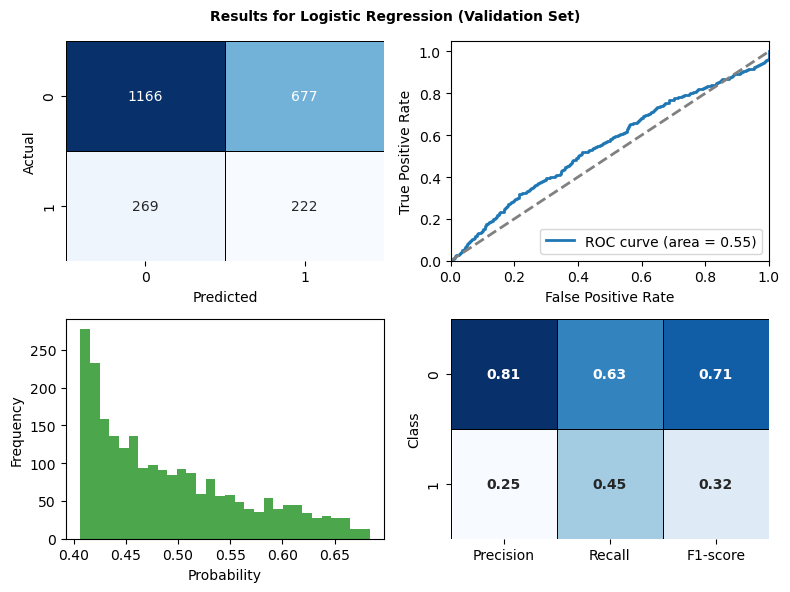


Random Forest Cross-Validation Results:
Mean F1-score: 0.3697 (+/- 0.0251)

Random Forest (Test Set):
Test Accuracy: 0.6158
Test Precision: 0.2652
Test Recall: 0.5635
Test F1-score: 0.3607

Random Forest (Validation Set):
  Val Accuracy: 0.6020
  Val Precision: 0.2695
  Val Recall: 0.5214
  Val F1-score: 0.3553
  Val AUC: 0.6159


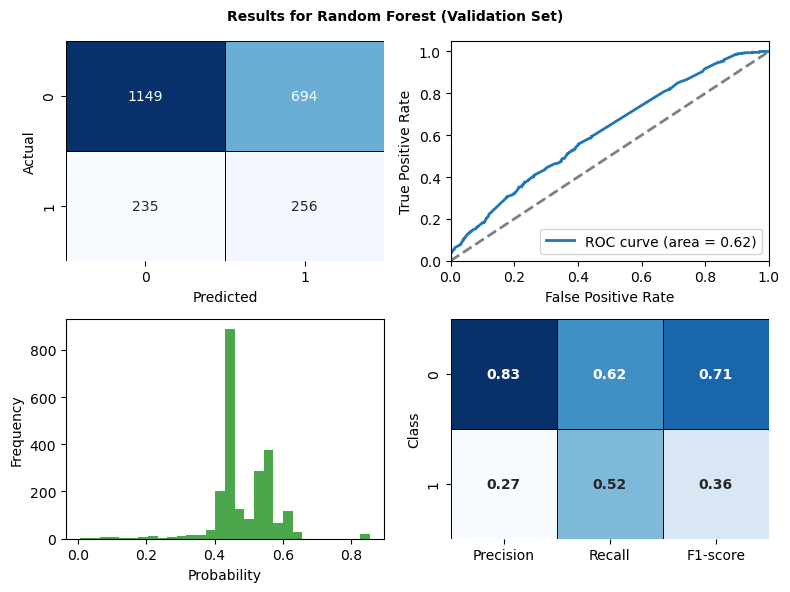


Gradient Boosting Cross-Validation Results:
Mean F1-score: 0.0806 (+/- 0.0407)

Gradient Boosting (Test Set):
Test Accuracy: 0.8141
Test Precision: 0.9412
Test Recall: 0.0356
Test F1-score: 0.0687

Gradient Boosting (Validation Set):
  Val Accuracy: 0.7973
  Val Precision: 1.0000
  Val Recall: 0.0367
  Val F1-score: 0.0707
  Val AUC: 0.6100


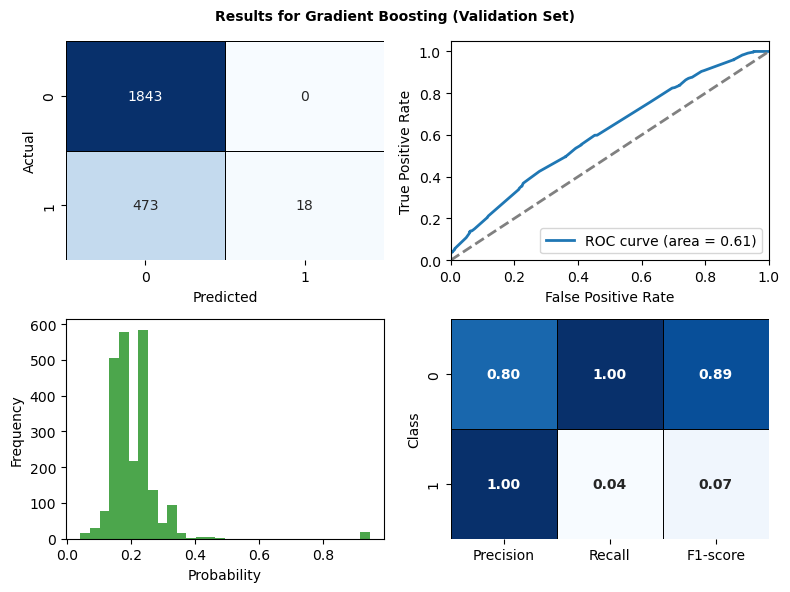


SVM Cross-Validation Results:
Mean F1-score: 0.3290 (+/- 0.0386)

SVM (Test Set):
Test Accuracy: 0.6617
Test Precision: 0.2582
Test Recall: 0.4053
Test F1-score: 0.3154

SVM (Validation Set):
  Val Accuracy: 0.7896
  Val Precision: 1.0000
  Val Recall: 0.0000
  Val F1-score: 0.0000
  Val AUC: 0.5542


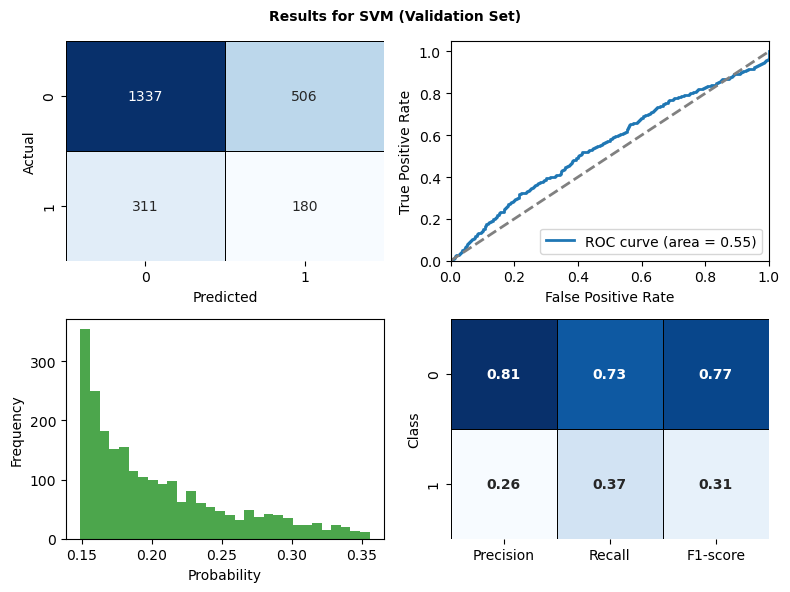

In [20]:
def parallel_cross_val(model, X_train, y_train, cv=5):
    return cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)

def cross_validate_and_evaluate(model, X_train, y_train, X_test, y_test, X_val, y_val, model_name, cv=5):
    cv_scores = parallel_cross_val(model, X_train, y_train, cv=cv)
    
    print(f"\n{model_name} Cross-Validation Results:")
    print(f"Mean F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    model.fit(X_train, y_train)
    
    y_test_pred = model.predict(X_test)
    print(f"\n{model_name} (Test Set):")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Test Precision: {precision_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test Recall: {recall_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test F1-score: {f1_score(y_test, y_test_pred, zero_division=1):.4f}")
    
    if hasattr(model, "predict_proba"):
        y_val_pred_proba = model.predict_proba(X_val)[:, 1]
        y_val_pred = (y_val_pred_proba >= 0.5).astype(int)  # Threshold set to 0.5
        val_results = {
            'Val Accuracy': accuracy_score(y_val, y_val_pred),
            'Val Precision': precision_score(y_val, y_val_pred, zero_division=1),
            'Val Recall': recall_score(y_val, y_val_pred, zero_division=1),
            'Val F1-score': f1_score(y_val, y_val_pred, zero_division=1),
            'Val AUC': roc_auc_score(y_val, y_val_pred_proba)
        }
        
        print(f"\n{model_name} (Validation Set):")
        for metric, value in val_results.items():
            print(f"  {metric}: {value:.4f}")
                
    Evaluation = ModelEvaluation(model, X_val, y_val, f'{model_name} (Validation Set)')    
    Evaluation.plot_evaluation()

# models = {
#     "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=500),
#     "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42),
#     "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
#     "SVM": SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42, probability=True)
# }

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=500),
    "Random Forest": RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    ),
    "SVM": SVC(
        kernel='linear',
        C=0.5,
        class_weight='balanced',
        random_state=42,
        probability=True
    )
}

for name, model in models.items():
    cross_validate_and_evaluate(model, X_train, y_train, X_test, y_test, X_val, y_val, name, cv=5)

# Experiment 2:

In this experiment, I retrieved the dataset from Open Target's [Bigquery](https://console.cloud.google.com/bigquery?sq=482968641421:b7b6580ad1204ef49b43fe66dcbeb478) database. To access the dataset, navigate through the link, create a project if you don't have one, and enable the BigQuery API. Then, change the EFO-ID to the ID of your desired disease, run the query, and download the dataset in CSV format

In [21]:
ot_df = pd.read_csv('../data/raw/cardiovascular_disease.csv')
ot_df

,target_id,target_approved_symbol,disease_id,disease_name,overall_direct_score,datasource_id,datasource_datatype_id,datasource_direct_score,datasource_direct_evidence_count,datatype_id,datatype_direct_score,datatype_direct_evidence_count,overall_indirect_score,overall_indirect_evidence_count
0,ENSG00000043591,ADRB1,EFO_0000319,cardiovascular disease,0.697763,chembl,known_drug,0.983531,45,literature,0.042817,9,0.732110,2049
1,ENSG00000043591,ADRB1,EFO_0000319,cardiovascular disease,0.697763,chembl,known_drug,0.983531,45,known_drug,0.983531,45,0.732110,2049
2,ENSG00000043591,ADRB1,EFO_0000319,cardiovascular disease,0.697763,chembl,known_drug,0.983531,45,genetic_association,0.653138,3,0.732110,2049
3,ENSG00000043591,ADRB1,EFO_0000319,cardiovascular disease,0.697763,europepmc,literature,0.042817,9,literature,0.042817,9,0.732110,2049
4,ENSG00000043591,ADRB1,EFO_0000319,cardiovascular disease,0.697763,europepmc,literature,0.042817,9,known_drug,0.983531,45,0.732110,2049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4535,ENSG00000187098,MITF,EFO_0000319,cardiovascular disease,0.001478,europepmc,literature,0.012159,1,literature,0.012159,1,0.414928,94
4536,ENSG00000100105,PATZ1,EFO_0000319,cardiovascular disease,0.001478,europepmc,literature,0.012159,1,literature,0.012159,1,0.251439,12
4537,ENSG00000135898,GPR55,EFO_0000319,cardiovascular disease,0.001478,europepmc,literature,0.012159,1,literature,0.012159,1,0.081770,25
4538,ENSG00000093134,VNN3P,EFO_0000319,cardiovascular disease,0.001478,europepmc,literature,0.012159,1,literature,0.012159,1,0.001478,1


In [22]:
ot_df.isnull().sum()

target_id                           0
target_approved_symbol              0
disease_id                          0
disease_name                        0
overall_direct_score                0
datasource_id                       0
datasource_datatype_id              0
datasource_direct_score             0
datasource_direct_evidence_count    0
datatype_id                         0
datatype_direct_score               0
datatype_direct_evidence_count      0
overall_indirect_score              0
overall_indirect_evidence_count     0
dtype: int64

In [23]:
ot_df = ot_df[['target_approved_symbol', 'overall_direct_score']]
ot_df

,target_approved_symbol,overall_direct_score
0,ADRB1,0.697763
1,ADRB1,0.697763
2,ADRB1,0.697763
3,ADRB1,0.697763
4,ADRB1,0.697763
...,...,...
4535,MITF,0.001478
4536,PATZ1,0.001478
4537,GPR55,0.001478
4538,VNN3P,0.001478


In [24]:
# ppi dataset stays the same
ppi_df

,GeneName1,GeneName2,experimental
0,ARF5,RALGPS2,0.134
1,ARF5,FHDC1,0.128
2,ARF5,ATP6V1E1,0.049
3,ARF5,CYTH2,0.053
4,ARF5,PSD3,0.046
...,...,...,...
5847701,LDB1,ZBTB7B,0.089
5847702,LDB1,LHX4,0.843
5847703,LDB1,ZNF319,0.089
5847704,LDB1,KDM6B,0.066


In [25]:
print("Creating graph...")
G = nx.Graph()

# Add OpenTargets edges
diseases = ['cardiovascular']
positive_edges = [(disease, row['target_approved_symbol'], {'weight': row['overall_direct_score'], 'type': 'disease-gene'})
                  for disease in diseases
                  for _, row in ot_df.iterrows() if row['overall_direct_score'] > 0.1]
G.add_edges_from(positive_edges)
print(f"Number of positive edges: {len(positive_edges)}")

top_positive_edges = sorted(positive_edges, key=lambda x: x[2]['weight'], reverse=True)[:int(0.3 * len(positive_edges))]
print(f"Number of top positive edges (30%): {len(top_positive_edges)}")

# Add PPI edges
ppi_edges_added = 0
for _, row in tqdm(ppi_filtered.iterrows(), total=len(ppi_filtered), desc="Adding PPI edges"):
    if row['GeneName1'] != row['GeneName2']:
        G.add_edge(row['GeneName1'], row['GeneName2'], type='ppi')
        ppi_edges_added += 1
print(f"Number of PPI edges added: {ppi_edges_added}")

Creating graph...
Number of positive edges: 1402
Number of top positive edges (30%): 420


Adding PPI edges: 100%|██████████| 5000000/5000000 [03:38<00:00, 22883.40it/s]

Number of PPI edges added: 4999993


In [26]:
# Generate negative examples for disease-gene interactions
print("Generating negative examples for disease-gene interactions...")
all_genes = set(ppi_filtered['GeneName1']).union(set(ppi_filtered['GeneName2']))
print(f"Total unique genes in PPI network: {len(all_genes)}")

negative_edges = []
for disease in diseases:
    associated_genes = set(G.neighbors(disease))
    print(f"Genes associated with {disease}: {len(associated_genes)}")
    non_associated_genes = all_genes - associated_genes
    print(f"Genes not associated with {disease}: {len(non_associated_genes)}")
    disease_negative_edges = [(disease, gene) for gene in non_associated_genes]
    negative_edges.extend(disease_negative_edges)
    
print(f"Number of potential negative edges: {len(negative_edges)}")

# Maintain imbalance
desired_ratio = 10  # 10 times more negative than positive
num_negative_samples = min(len(negative_edges), desired_ratio * len(positive_edges))
negative_edges = random.sample(negative_edges, num_negative_samples)
print(f'\nTotal number of edges: {len(positive_edges + negative_edges )}')
print(f"Final number of positive edges: {len(positive_edges)}")
print(f"Final number of negative edges: {len(negative_edges)}")


# Additional diagnostics
print("\nAdditional Diagnostics:")
print(f"Total nodes in graph: {G.number_of_nodes()}")
print(f"Total edges in graph: {G.number_of_edges()}")
print(f"Nodes with {diseases[0]} as neighbor: {len(list(G.neighbors(diseases[0])))}")
ot_genes = set(ot_df['target_approved_symbol'])
ppi_genes = set(ppi_filtered['GeneName1']).union(set(ppi_filtered['GeneName2']))
print(f"Genes in OpenTargets: {len(ot_genes)}")
print(f"Genes in PPI network: {len(ppi_genes)}")

Generating negative examples for disease-gene interactions...
Total unique genes in PPI network: 18531
Genes associated with cardiovascular: 613
Genes not associated with cardiovascular: 17936
Number of potential negative edges: 17936

Total number of edges: 15422
Final number of positive edges: 1402
Final number of negative edges: 14020

Additional Diagnostics:
Total nodes in graph: 18550
Total edges in graph: 2759560
Nodes with cardiovascular as neighbor: 613
Genes in OpenTargets: 3480
Genes in PPI network: 18531


In [27]:
# Simple embedding model
g2v = Node2Vec(
    n_components=32,
    walklen=10
)

print("Training Node2Vec model...")
g2v.fit(G)

Training Node2Vec model...
Making walks... Done, T=0.44
Mapping Walk Names... Done, T=2.54
Training W2V... Done, T=140.10


In [28]:
embeddings = g2v.model.wv
# Print embeddings for a specific node (e.g., cardiovascular disease)
print(f"Embeddings for node '{diseases[0]}':\n")
print(embeddings[str(diseases[0])])

Embeddings for node 'cardiovascular':

[-0.62549263 -0.15364662  0.9103299  -2.3022652   1.1859615   0.8870774
 -2.2300248   2.5120342   0.6560241   0.47758567  2.4519722  -1.31511
 -1.0053518  -0.4676164  -0.02337564 -1.9177991  -1.301164   -3.1396124
 -0.5541052  -0.6147641   2.504456   -0.17779088  2.051588   -2.5727515
  0.52402085 -1.9466552  -1.3295431   0.00482331  0.51297146  0.10755818
 -1.4238389  -1.4532561 ]


In [29]:
# Function to get edge features
def get_edge_features(edge, embeddings):
    return embeddings[edge[0]] * embeddings[edge[1]]

# Generate features for positive and negative edges
X_positive = np.array([get_edge_features(edge, embeddings) for edge in positive_edges])
X_negative = np.array([get_edge_features(edge, embeddings) for edge in negative_edges])
X = np.vstack((X_positive, X_negative))
y = np.array([1] * len(positive_edges) + [0] * len(negative_edges))

# Print sample data
print(f'Sample from X: {X[0:1]}')
print(f'Sample from y: {y[0:1]}')

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

Sample from X: [[-4.6868515e-01  2.2815686e-01  3.5193053e-01  2.0238254e+00
   1.2510635e+00 -1.2730034e-01  2.7919199e+00  4.9807873e+00
   5.0958258e-01 -3.4157187e-01  3.1010079e+00 -7.1605124e-02
   3.1316358e-01 -5.4383302e-01  1.4473336e-02  2.4264612e+00
  -6.7662776e-02  3.7846344e+00 -1.3872145e-01  7.1996987e-02
   5.5544367e+00 -1.1377886e-01 -1.4992367e+00  4.5670962e+00
   6.0909700e-01 -4.4131660e-01  6.3801873e-01  3.9340925e-04
  -1.0773292e-01 -1.1865178e-02  6.6608864e-01  6.6278583e-01]]
Sample from y: [1]



Logistic Regression Cross-Validation Results:
Mean F1-score: 0.3496 (+/- 0.0247)

Logistic Regression (Test Set):
Test Accuracy: 0.7905
Test Precision: 0.2619
Test Recall: 0.7341
Test F1-score: 0.3860

Logistic Regression (Validation Set):
  Val Accuracy: 0.7853
  Val Precision: 0.2591
  Val Recall: 0.7273
  Val F1-score: 0.3821
  Val AUC: 0.8047


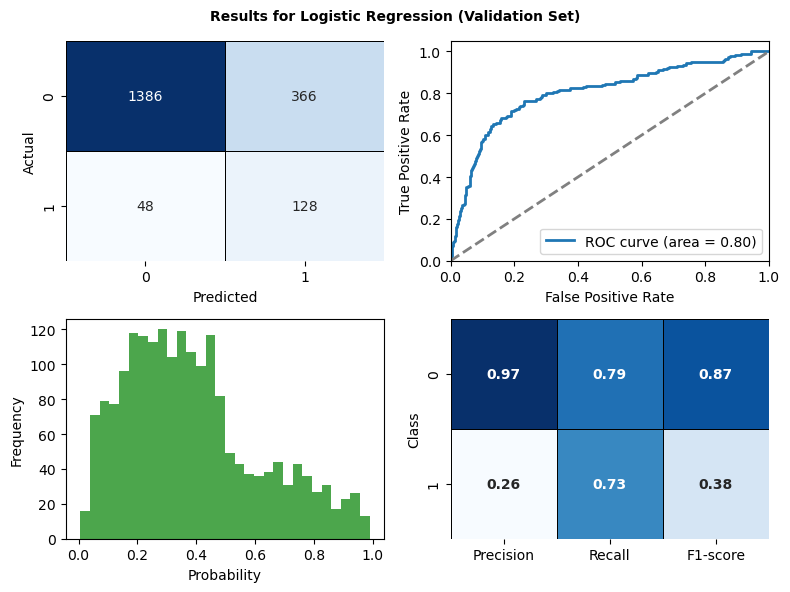


Random Forest Cross-Validation Results:
Mean F1-score: 0.7129 (+/- 0.0440)

Random Forest (Test Set):
Test Accuracy: 0.9538
Test Precision: 0.7258
Test Recall: 0.7803
Test F1-score: 0.7521

Random Forest (Validation Set):
  Val Accuracy: 0.9487
  Val Precision: 0.6995
  Val Recall: 0.7670
  Val F1-score: 0.7317
  Val AUC: 0.9149


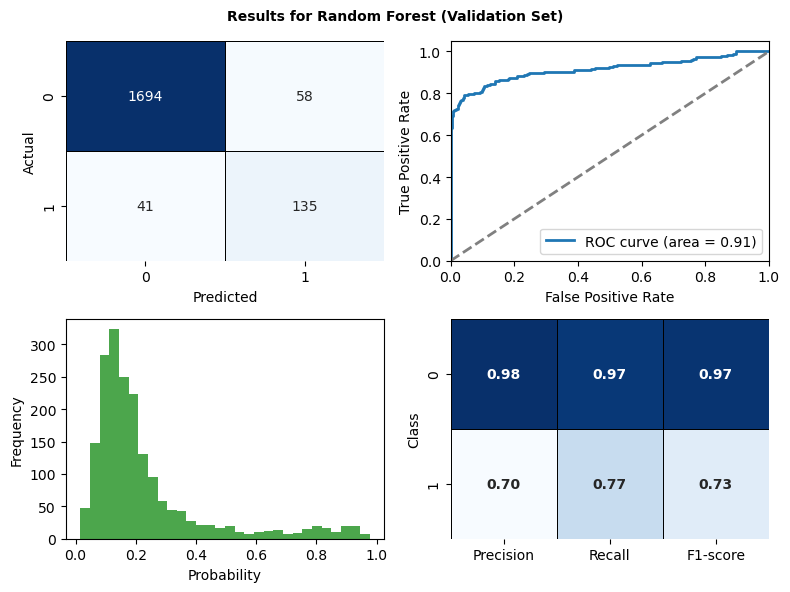


Gradient Boosting Cross-Validation Results:
Mean F1-score: 0.3293 (+/- 0.0768)

Gradient Boosting (Test Set):
Test Accuracy: 0.9295
Test Precision: 0.8364
Test Recall: 0.2659
Test F1-score: 0.4035

Gradient Boosting (Validation Set):
  Val Accuracy: 0.9232
  Val Precision: 0.8043
  Val Recall: 0.2102
  Val F1-score: 0.3333
  Val AUC: 0.8445


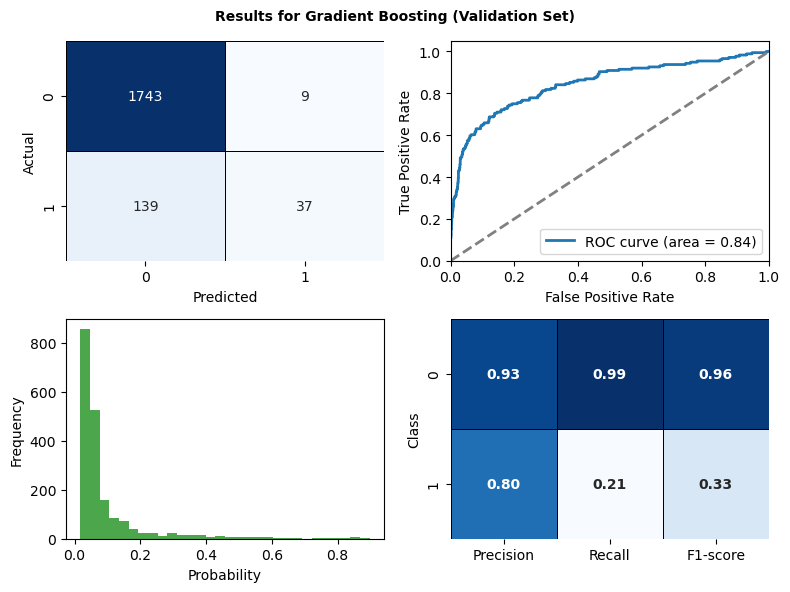


SVM Cross-Validation Results:
Mean F1-score: 0.3679 (+/- 0.0276)

SVM (Test Set):
Test Accuracy: 0.8060
Test Precision: 0.2762
Test Recall: 0.7168
Test F1-score: 0.3987

SVM (Validation Set):
  Val Accuracy: 0.9056
  Val Precision: 0.4318
  Val Recall: 0.1080
  Val F1-score: 0.1727
  Val AUC: 0.8046


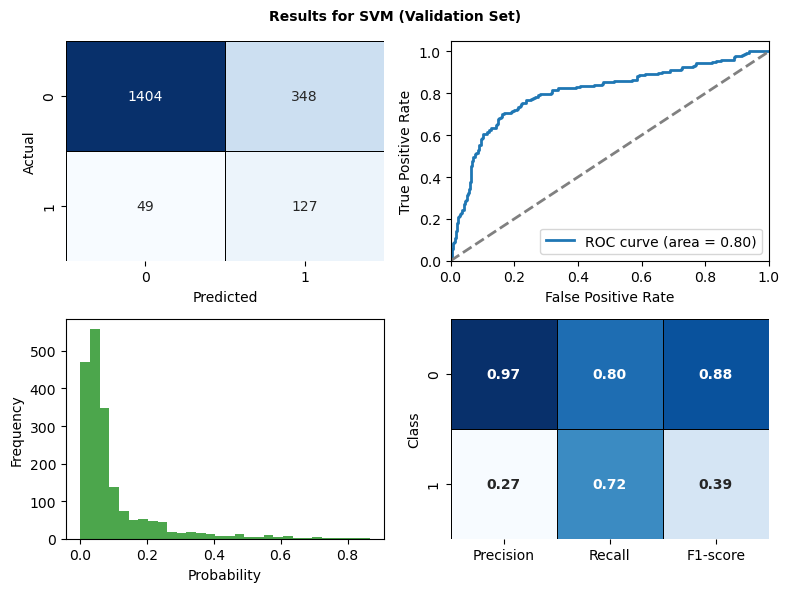

Training sequential API model...

Sequential Evaluation Results
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9557 - loss: 0.1499
Test Loss: 0.1437, Test Accuracy: 0.9585
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Sequential (Test Set):
Test Accuracy: 0.9585
Test Precision: 0.8444
Test Recall: 0.6590
Test F1-score: 0.7403
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Sequential (Validation Set):
  Val Accuracy: 0.9544
  Val Precision: 0.8438
  Val Recall: 0.6136
  Val F1-score: 0.7105
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


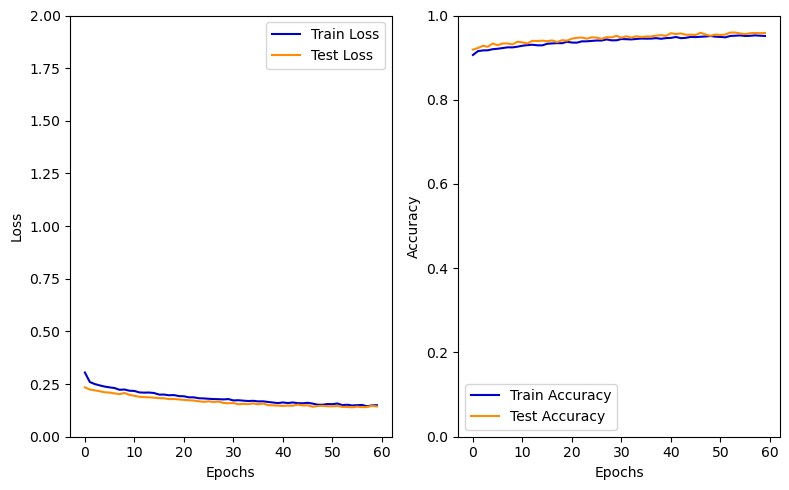

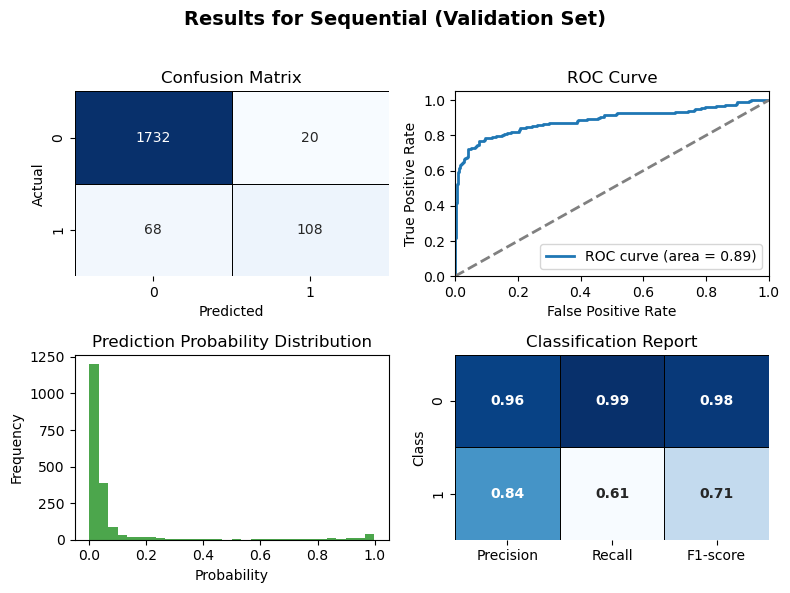

In [30]:
def parallel_cross_val(model, X_train, y_train, cv=5):
    return cross_val_score(model, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1)

def cross_validate_and_evaluate(model, X_train, y_train, X_test, y_test, X_val, y_val, model_name, cv=5):
    cv_scores = parallel_cross_val(model, X_train, y_train, cv=cv)
    
    print(f"\n{model_name} Cross-Validation Results:")
    print(f"Mean F1-score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
    
    model.fit(X_train, y_train)
    
    y_test_pred = model.predict(X_test)
    print(f"\n{model_name} (Test Set):")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Test Precision: {precision_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test Recall: {recall_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test F1-score: {f1_score(y_test, y_test_pred, zero_division=1):.4f}")
    
    if hasattr(model, "predict_proba"):
        y_val_pred_proba = model.predict_proba(X_val)[:, 1]
        y_val_pred = (y_val_pred_proba >= 0.5).astype(int)  # Threshold set to 0.5
        val_results = {
            'Val Accuracy': accuracy_score(y_val, y_val_pred),
            'Val Precision': precision_score(y_val, y_val_pred, zero_division=1),
            'Val Recall': recall_score(y_val, y_val_pred, zero_division=1),
            'Val F1-score': f1_score(y_val, y_val_pred, zero_division=1),
            'Val AUC': roc_auc_score(y_val, y_val_pred_proba)
        }
        
        print(f"\n{model_name} (Validation Set):")
        for metric, value in val_results.items():
            print(f"  {metric}: {value:.4f}")
                
    Evaluation = ModelEvaluation(model, X_val, y_val, f'{model_name} (Validation Set)')    
    Evaluation.plot_evaluation()

# models = {
#     "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=500),
#     "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42),
#     "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
#     "SVM": SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42, probability=True)
# }

models = {
    "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=500),
    "Random Forest": RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        class_weight='balanced',
        random_state=42
    ),
    "Gradient Boosting": GradientBoostingClassifier(
        n_estimators=50,
        max_depth=3,
        learning_rate=0.1,
        random_state=42
    ),
    "SVM": SVC(
        kernel='linear',
        C=0.5,
        class_weight='balanced',
        random_state=42,
        probability=True
    )
}

for name, model in models.items():
    cross_validate_and_evaluate(model, X_train, y_train, X_test, y_test, X_val, y_val, name, cv=5)
    
    

def sequential_model(X_train, y_train, X_test, y_test, X_val, y_val):
    
    X_train = tf.constant(X_train)
    y_train = tf.constant(y_train)
    X_test = tf.constant(X_test)
    y_test = tf.constant(y_test)
    X_val = tf.constant(X_val)
    y_val = tf.constant(y_val)
    
    # model = Sequential([
    #     Dense(128, activation="relu"),
    #     Dropout(0.5),
    #     Dense(256, activation="relu"),
    #     Dropout(0.5),
    #     Dense(128, activation="relu"),
    #     Dense(1, activation="sigmoid")
    # ])
    
    model = Sequential([
        Dense(64, activation="relu"),
        Dropout(0.3),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(64, activation="relu"),
        Dense(1, activation="sigmoid")
    ])

    model.compile(
        loss="binary_crossentropy",
        optimizer="adam", #tf.keras.optimizers.Adam(learning_rate=0.001),
        metrics=["accuracy"]
    )

    # Fit the model
    print('Training sequential API model...')
    history = model.fit(
        X_train,
        y_train,
        epochs=60,
        validation_data=(X_test, y_test),
        verbose=0
    )

    model_name = 'Sequential'
    print(f"\n{model_name} Evaluation Results")
    res = model.evaluate(X_test, y_test)
    print(f"Test Loss: {res[0]:.4f}, Test Accuracy: {res[1]:.4f}")
    
    
    
    y_test_pred = (model.predict(X_test) >= 0.5).astype(int)
    print(f"\n{model_name} (Test Set):")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Test Precision: {precision_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test Recall: {recall_score(y_test, y_test_pred, zero_division=1):.4f}")
    print(f"Test F1-score: {f1_score(y_test, y_test_pred, zero_division=1):.4f}")


    y_val_pred = (model.predict(X_val) >= 0.5).astype(int)
    val_results = {
        'Val Accuracy': accuracy_score(y_val, y_val_pred),
        'Val Precision': precision_score(y_val, y_val_pred, zero_division=1),
        'Val Recall': recall_score(y_val, y_val_pred, zero_division=1),
        'Val F1-score': f1_score(y_val, y_val_pred, zero_division=1)
    }

    print(f"\n{model_name} (Validation Set):")
    for metric, value in val_results.items():
        print(f"  {metric}: {value:.4f}")
        
    Evaluation = TfEvaluation(model, X_val, y_val, f'{model_name} (Validation Set)', history)
    Evaluation.plot_history()        
    Evaluation.plot_evaluation()


sequential_model(X_train, y_train, X_test, y_test, X_val, y_val)